In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
K_real.shape

(2016, 75)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

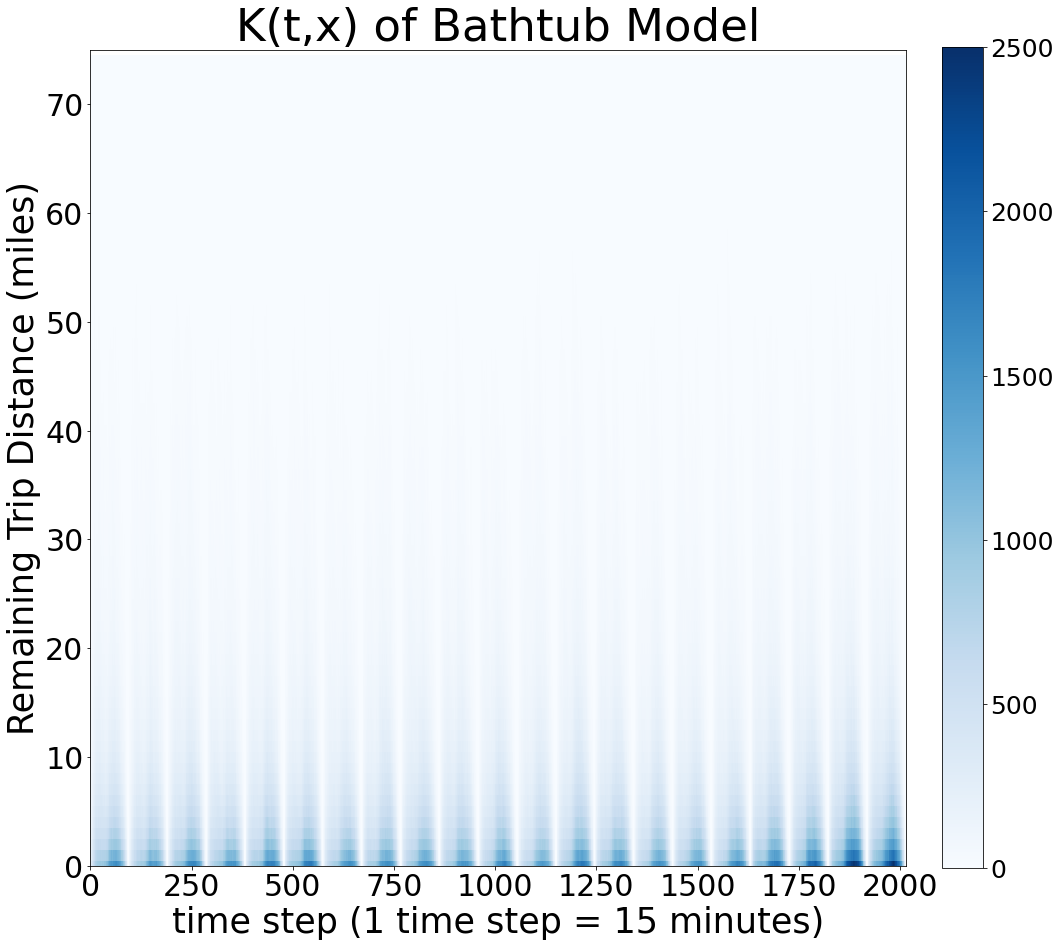

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 1 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  75600
N_u =  15120
N_f =  30240


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(15120, 2)

In [12]:
X_u_test.shape

(60480, 2)

In [13]:
X_u_train

array([[0.40540541, 0.31364764],
       [0.45945946, 0.35037221],
       [0.67567568, 0.81885856],
       ...,
       [0.17567568, 0.97866005],
       [0.32432432, 0.54094293],
       [0.63513514, 0.21736973]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0028801102936232377 0.0050499228939217666 0.00071029769332470855 0.7824360720848788
0.002838007566026801 0.0050368644512130845 0.00063915068084051722 0.7811637355663451
0.0028124409661997064 0.0050374088220343323 0.0005874731103650805 0.7809382773075219
0.0027830462919980984 0.0050130139600031735 0.00055307862399302341 0.778812284579551
0.0027083563420232009 0.0049250696954589012 0.00049164298858750052 0.7714249859910307
0.002634260860496894 0.0048442954737564657 0.00042422624723732218 0.7645173348335896
0.0025730036655494844 0.0048105795848611341 0.0003354277462378351 0.7618024715367593
0.0025427645013611968 0.0047972087126305751 0.00028832029009181819 0.7609213223773511
0.0025330747212684458 0.004792741653642258 0.00027340778889463335 0.7608567083051103
0.0025224669989947456 0.0047899521462255058 0.00025498185176398567 0.760968139679501
0.0025170576717213245 0.0047887709926218627 0.00024534435082078663 0.761020183496597
0.0025119553392854268 0.0047865788436153344 0.0002373318349555

0.0015759715972067383 0.0026816364665030921 0.00047030672791038445 0.5802637028095321
0.0015758898643394542 0.0026811887100426047 0.00047059101863630362 0.580189206019735
0.001575864788307125 0.00268160142954334 0.00047012814707090992 0.580216462272069
0.0015758419832929706 0.00268259064683674 0.00046909331974920125 0.5803067957821328
0.0015758346425603575 0.0026830239821308477 0.00046864530298986736 0.5803480578659302
0.0015758211903889742 0.0026829239966137688 0.00046871838416417949 0.5803306075169175
0.001575801349094822 0.002682921811511957 0.00046868088667768675 0.5803187851394757
0.0015757885313380958 0.0026826802374953335 0.000468896825180858 0.5802825916721747
0.0015757727159016735 0.0026826534464900447 0.000468891985313302 0.5802698136426344
0.0015757459457653106 0.0026827601935634623 0.00046873169796715874 0.5802681455353741
0.0015756687699848989 0.0026826561293293335 0.00046868141064046405 0.5802318636935512
0.0015755483829505825 0.0026830186654741824 0.00046807810042698235 

0.0015705159939370633 0.0026709525258301488 0.00047007946204397755 0.5788998079415685
0.0015704986397661661 0.002669784268543994 0.00047121301098833823 0.5787668495479817
0.0015704603015882349 0.0026694255862671767 0.0004714950169092933 0.5787312450323181
0.0015704112809995952 0.0026698041464494403 0.00047101841554975007 0.5787744435642455
0.0015703966683975588 0.0026695297442097875 0.00047126359258533034 0.5787349817772981
0.0015703575445395776 0.0026690206137563845 0.00047169447532277061 0.5786820813553513
0.001570334601983879 0.0026682490258914124 0.00047242017807634542 0.5786234994300294
0.0015703255630269573 0.0026673742722723268 0.00047327685378158781 0.5785251925253757
0.0015703146047475187 0.0026669029209708231 0.00047372628852421439 0.5784738429225262
0.0015703032754932353 0.0026674158468761346 0.00047319070411033629 0.5785401059312449
0.0015702988934616362 0.0026668755136000353 0.00047372227332323686 0.5784894624684188
0.0015702963564947782 0.0026671055736672312 0.00047348713

0.001569563730223383 0.0026673097054562278 0.00047181775499053827 0.5784131168010065
0.0015695467766900094 0.0026695382668739174 0.00046955528650610153 0.578654352630966
0.0015695380789597841 0.00266987583201684 0.00046920032590272827 0.5787002226660347
0.0015695267904398014 0.0026690282510657987 0.00047002532981380414 0.5785872874778468
0.0015695172228188793 0.0026693362946358687 0.00046969815100188992 0.5786199886658351
0.0015695050187612297 0.00266998930874446 0.00046902072877799949 0.5786925553879934
0.0015694840782896321 0.0026704272698902026 0.00046854088668906162 0.5787376857320343
0.001569450240234857 0.0026708035165989479 0.00046809696387076617 0.578783451947411
0.0015694267479408391 0.0026703185724194522 0.00046853492346222612 0.5787220713243995
0.0015694035233399255 0.002667402531080033 0.00047140451559981797 0.5784031290980546
0.0015693528871794683 0.0026683136122094236 0.00047039216214951287 0.5784990321121934
0.0015693402787570507 0.0026687060772999731 0.00046997448021412

0.0015689252641107954 0.0026666972826827335 0.00047115324553885724 0.5782435990883359
0.0015689157021485797 0.00266671271728984 0.0004711186870073196 0.5782385930170193
0.0015689127829236612 0.0026666547757938043 0.0004711707900535183 0.5782338576488991
0.0015689027456221171 0.0026672793782931748 0.00047052611295105907 0.5783070832549152
0.0015688975545058283 0.0026667532198251464 0.00047104188918651018 0.5782511305711361
0.0015688917184017003 0.0026665626723093357 0.00047122076449406479 0.5782464467493971
0.0015688903015790079 0.0026663967276711153 0.00047138387548690039 0.5782209704184593
0.0015688897011882971 0.0026663219052006403 0.00047145749717595389 0.5782128325191811
0.0015688881790007756 0.002666787408312271 0.00047098894968928043 0.578264245605874
0.0015688858235072206 0.0026670713737888376 0.00047070027322560382 0.5782957179832878
0.0015688831303619761 0.0026674666097574224 0.00047029965096652963 0.578339386846904
0.0015688785550123905 0.0026672744645902797 0.000470482645434

0.0015678523865137687 0.0026645345530821756 0.00047117021994536187 0.5778170253883669
0.0015678419601068549 0.0026644316944112495 0.00047125222580246003 0.5778012644554439
0.0015678276459401253 0.0026641382650434229 0.00047151702683682792 0.5777633823047903
0.0015678121780470559 0.0026640577573212774 0.0004715665987728343 0.5777619122628527
0.0015677996722864326 0.0026643402288362124 0.00047125911573665281 0.5777891936940149
0.0015677938409216201 0.0026639521381427249 0.00047163554370051525 0.5777496252770152
0.001567783426211901 0.0026633590782675683 0.00047220777415623335 0.5776974765711362
0.0015677716216024409 0.0026631756802921159 0.00047236756291276611 0.5776717213942063
0.0015677657247421767 0.0026623129898132344 0.00047321845967111895 0.5776003696044922
0.0015677484785445702 0.0026625662188342371 0.00047293073825490311 0.5776206566208695
0.0015677406232898815 0.0026628648059516496 0.00047261644062811334 0.5776470528057492
0.0015677334027490613 0.0026638053950299636 0.0004716614

0.0015673496458844089 0.0026653969140939971 0.00046930237767482083 0.5779359156189512
0.001567347723392109 0.0026653378706761308 0.00046935757610808718 0.5779238561383688
0.0015673450291451866 0.0026650831513641083 0.00046960690692626517 0.5778964579709658
0.0015673383405288002 0.0026648557102519959 0.00046982097080560433 0.5778666551038933
0.0015673350168569444 0.0026649471234645719 0.00046972291024931695 0.5778792009754345
0.0015673321837211119 0.0026652948333588536 0.00046936953408337006 0.5779288819789541
0.0015673304090061144 0.0026653371732166336 0.00046932364479559512 0.5779345017191724
0.0015673281190778468 0.0026649144413546082 0.00046974179680108543 0.5778962707093028
0.001567326649177637 0.0026651824840799362 0.00046947081427533785 0.5779253080553248
0.0015673250669394783 0.0026652652398525684 0.00046938489402638828 0.5779355510726488
0.0015673225184625467 0.0026653948770018429 0.00046925015992325069 0.5779510928202148
0.0015673163137924111 0.0026649368567498695 0.0004696957

0.0015662480029325458 0.0026675164597317088 0.00046497954613338284 0.5782218185918494
0.0015662344916895867 0.0026676221409048851 0.00046484684247428824 0.5782303434380862
0.0015661882173588926 0.002667063300410577 0.0004653131343072085 0.5781504229629159
0.0015661344282079663 0.0026684635765572128 0.00046380527985871961 0.578298747801442
0.0015661077236422424 0.0026679306341032103 0.00046428481318127473 0.5782321256628056
0.0015660473192813309 0.0026667646741704971 0.00046532996439216465 0.5781007991976683
0.0015660134611479378 0.0026666741653648828 0.00046535275693099281 0.5780910918081306
0.0015659464091670528 0.0026643973509301571 0.00046749546740394867 0.5778501158714856
0.0015659213615502098 0.0026667334964012423 0.00046510922669917713 0.5781005566260998
0.0015659039670175544 0.0026697072406229126 0.00046210069341219616 0.5784069272817468
0.0015658788691858294 0.0026684317962775775 0.000463325942094081 0.578283768256623
0.0015658680374593008 0.0026664720746546289 0.00046526400026

0.0015581830128357592 0.0026537690756465843 0.00046259695002493433 0.5767837406769499
0.0015580994989682763 0.0026519484129849634 0.0004642505849515891 0.5766492304822038
0.0015580260032317032 0.0026525921153505859 0.0004634598911128203 0.5766479107807845
0.0015579686428659836 0.0026537332452438063 0.00046220404048816108 0.5767095040134264
0.0015578584251460502 0.0026544508091442642 0.000461266041147836 0.5768228319464991
0.0015577699111556016 0.002654576623370839 0.00046096319894036407 0.5768465973234207
0.00155766426222805 0.0026559393475927835 0.00045938917686331662 0.5769586083692148
0.0015575897510845815 0.0026567533646667074 0.00045842613750245572 0.5770701423198936
0.0015574979278773458 0.0026563601016487692 0.00045863575410592234 0.5770517037337278
0.0015574259490421685 0.0026546701462455365 0.00046018175183880063 0.5768572259310212
0.0015573902383067273 0.0026527593138711953 0.00046202116274225908 0.5767176377580759
0.0015573430904134915 0.0026530950796511237 0.000461591101175

0.0015549671164800424 0.0026479695298016605 0.00046196470315842437 0.5762271583211933
0.0015549632350891039 0.0026475533966735577 0.00046237307350465009 0.5761829488890013
0.0015549571396459533 0.0026472051245704994 0.00046270915472140724 0.5761432495144433
0.0015549457286540579 0.0026470411061677904 0.00046285035114032526 0.5761187349949621
0.001554929610036726 0.0026466960087161442 0.00046316321135730785 0.5760826086415538
0.0015549058117693012 0.0026470017109417872 0.000462809912596815 0.5760929960150043
0.0015548882228010594 0.0026460231149672145 0.00046375333063490435 0.5760110661023568
0.0015548462146671934 0.0026483800494218855 0.00046131237991250149 0.5762541772554016
0.0015548145800596113 0.0026474268772454109 0.00046220228287381188 0.5761427651748251
0.0015547756385366931 0.0026484999172160188 0.00046105135985736746 0.5762578007022722
0.0015547320775320551 0.0026473981853423838 0.00046206596972172648 0.5761752115839629
0.0015546875284400035 0.0026485983459387688 0.00046077671

0.0015516848720531081 0.0026457577352464175 0.00045761200885979862 0.5761034807021688
0.0015516525275963591 0.0026460130008923014 0.00045729205430041685 0.5761255438318065
0.0015516010132788432 0.0026452013326162711 0.00045800069394141542 0.5760301860510056
0.00155156603439232 0.002645594544381227 0.00045753752440341316 0.5760820494185142
0.0015515330579186756 0.00264541396615507 0.00045765214968228123 0.5760601604988688
0.0015515179351482723 0.0026444466418963819 0.00045858922840016268 0.5759635519281755
0.0015515012948020244 0.0026449749534432875 0.0004580276361607615 0.5760202158615532
0.0015514843083482938 0.002644974508948 0.00045799410774858743 0.5760119846215921
0.0015514727584828793 0.0026444891516306844 0.00045845636533507414 0.5759591814695392
0.0015514563214114427 0.0026446721502895185 0.000458240492533367 0.5759756270666896
0.0015514370264170204 0.0026433283961959822 0.00045954565663805855 0.5758148296322952
0.0015514260943396765 0.0026443806724543817 0.00045847151622497142

0.0015505746222821909 0.0026440804084809783 0.00045706883608340377 0.5758065528586439
0.0015505698310505688 0.0026439569125867807 0.00045718274951435693 0.5757893253545122
0.001550563908787926 0.0026426673530348496 0.0004584604645410024 0.5756640783149377
0.0015505513720413997 0.0026434930859215939 0.00045760965816120565 0.5757487923043825
0.0015505420224334293 0.0026441053540028512 0.00045697869086400747 0.5758061883612732
0.0015505381452608842 0.0026443085893723406 0.0004567677011494277 0.5758408131964504
0.0015505289094670679 0.0026440732466641065 0.00045698457227002912 0.5758094545564285
0.001550524189120118 0.0026441430280377543 0.00045690535020248183 0.5758151781603736
0.0015505176719572116 0.0026436574252679391 0.00045737791864648426 0.5757604974130885
0.0015505099828062652 0.0026444576673982866 0.000456562298214244 0.5758511969797889
0.0015505060334929559 0.0026447136004659347 0.00045629846651997706 0.5758723413091169
0.0015504964213261493 0.0026441379919605081 0.00045685485069

0.0015498362647104848 0.0026421680612005063 0.00045750446822046345 0.5755642798703605
0.0015498096382442544 0.0026427330890742575 0.0004568861874142511 0.5756113008996032
0.0015497826097169189 0.0026435204558883786 0.00045604476354545897 0.5757020040465641
0.0015497655086894823 0.0026428303490120078 0.0004567006683669566 0.5756112365234455
0.0015497600116378793 0.0026401930799101023 0.00045932694336565634 0.5753087431255286
0.0015497412393258598 0.0026416831549622068 0.00045779932368951296 0.5754658500362053
0.0015497266988910613 0.0026426569648325539 0.00045679643294956892 0.5755685355970084
0.0015497086107236927 0.0026428396018801947 0.00045657761956719069 0.575592928479468
0.0015497030528136468 0.0026436983474062859 0.00045570775822100775 0.5756842596902474
0.0015496812890226214 0.0026410636704664722 0.00045829890757877054 0.5754085910639154
0.0015496729530440508 0.0026412852767371069 0.00045806062935099454 0.5754370490586619
0.0015496576684403333 0.0026411341828245821 0.00045818115

0.0015480467495584856 0.0026394868432113952 0.00045660665590557619 0.5754711127709364
0.0015480164377090488 0.0026381409414337025 0.00045789193398439512 0.5753343942712897
0.0015479773829365408 0.002636427652680583 0.00045952711319249888 0.575143611748263
0.001547943378891804 0.0026369170032164218 0.00045896975456718623 0.5751962413268884
0.0015479184372789905 0.0026360164792981113 0.00045982039525986975 0.5750972829831096
0.0015478914910194187 0.00263779904595399 0.00045798393608484757 0.57526547775986
0.0015478637776850793 0.0026372909725236792 0.00045843658284647947 0.5752493958146241
0.0015478384686151939 0.0026357783636459706 0.00045989857358441719 0.575088317889377
0.0015478145916908311 0.0026357908238128164 0.000459838359568846 0.5750729612304387
0.0015477940077035064 0.0026360171451802069 0.00045957087022680584 0.5750970473768447
0.001547777093149484 0.0026372371691922632 0.00045831701710670453 0.5752243028756756
0.001547763949357383 0.0026370195068679981 0.00045850839184676786

0.0015449536376105409 0.0026306817876495933 0.00045922548757148867 0.5745176752888548
0.0015448923304739266 0.0026329635919701655 0.00045682106897768765 0.5747550040563381
0.001544845573347184 0.0026329475861940252 0.00045674356050034244 0.5747631520829368
0.0015448338066245751 0.0026335159175754565 0.0004561516956736938 0.5748315475743175
0.0015448209634942292 0.0026327791860331563 0.000456862740955302 0.5747310491493463
0.0015447861026726497 0.0026331001484940874 0.00045647205685121214 0.5747778842996069
0.00154477009800484 0.0026326298426106263 0.00045691035339905377 0.5747207842938044
0.0015447622966406182 0.0026319739775501325 0.00045755061573110394 0.5746519132334577
0.001544750458918983 0.002631732400778426 0.00045776851705953993 0.5746294380951178
0.0015447356965363364 0.0026317575805819182 0.00045771381249075447 0.5746335454804856
0.0015447196847026619 0.0026319154046894693 0.00045752396471585461 0.5746457585205528
0.0015446984645704389 0.002631746741246064 0.00045765018789481

0.001542434305008829 0.0026301188463090041 0.0004547497637086541 0.5743899038423912
0.0015424280637315641 0.0026303124245561716 0.00045454370290695645 0.5744188337355604
0.0015424222882179425 0.00263043675619634 0.000454407820239545 0.5744311109676694
0.0015424166580043947 0.0026307922188202929 0.00045404109718849648 0.5744553485234714
0.0015424011787216077 0.0026303139453385635 0.00045448841210465191 0.5743925391287052
0.0015423883366645309 0.0026309828381616222 0.00045379383516743941 0.5744518515114144
0.0015423703656701874 0.0026321459182565218 0.00045259481308385292 0.5745494078219344
0.0015423673368753805 0.0026322100026541281 0.00045252467109663285 0.574570027473014
0.0015423486142833627 0.0026309928108756127 0.00045370441769111269 0.574437342534984
0.0015423394556290583 0.0026310546162184689 0.00045362429503964768 0.5744406885018086
0.0015423278836173512 0.0026310001501436918 0.00045365561709101031 0.5744417829605699
0.0015423237255573813 0.0026308100004015234 0.0004538374507132

0.0015382540739086921 0.0026269361070938189 0.00044957204072356533 0.5738521361919179
0.0015382370516759463 0.0026266793866792644 0.00044979471667262841 0.5738287363758906
0.0015382093496815537 0.0026267783176732364 0.00044964038168987118 0.5738583498890277
0.0015381953977763655 0.0026240816722930276 0.00045230912325970336 0.5735548005665114
0.0015381559144518 0.0026245789659075148 0.00045173286299608507 0.5736264197197316
0.0015381176015621517 0.002626348691559954 0.00044988651156434962 0.5738251468578867
0.0015380875400473621 0.002626596841216505 0.00044957823887821941 0.5738300197820018
0.00153806574822967 0.0026261783164688345 0.00044995317999050547 0.5737652728126553
0.0015380357306296513 0.0026261495714342076 0.00044992188982509478 0.5737705769160151
0.0015379939089574556 0.0026247807020565225 0.0004512071158583886 0.5736331946879064
0.0015379294460724688 0.0026243160622163239 0.00045154282992861366 0.5735870674346955
0.0015378732697607293 0.002622386674214524 0.00045335986530693

0.0015346866179357767 0.0026227552749122987 0.00044661796095925478 0.5732402807186275
0.0015346466405433549 0.0026228194617953829 0.00044647381929132691 0.5732500257273537
0.0015345969927493173 0.002623261876880376 0.00044593210861825839 0.5732945153262944
0.001534498048388914 0.0026237406918238585 0.00044525540495396959 0.5733335507232353
0.0015344351826023432 0.002624655944109737 0.00044421442109494956 0.5734330463962584
0.0015344024401213316 0.0026250774505702573 0.000443727429672406 0.5734437077216752
0.0015343642418267555 0.0026240530166479264 0.0004446754670055846 0.5733471291007844
0.0015343447945446477 0.002623830998410368 0.00044485859067892739 0.5733195665418851
0.0015343185612305735 0.0026239976269216508 0.00044463949553949636 0.5733253294639291
0.0015342813055529872 0.0026236082750372034 0.00044495433606877075 0.5732690057869921
0.0015342380070902969 0.0026231953224334545 0.00044528069174713927 0.5732103588181201
0.0015341420338598677 0.0026228468955122887 0.000445437172207

0.0015304533644670711 0.0026188629773127394 0.00044204375162140263 0.5728454143617803
0.0015303814797487409 0.0026177658708053993 0.00044299708869208247 0.5727351633223495
0.0015303248515578457 0.002617686878819856 0.00044296282429583551 0.5727226247592713
0.0015303065148023131 0.0026181222847330315 0.00044249074487159477 0.5727571995170687
0.0015302714464643784 0.0026177153619813 0.00044282753094745676 0.5727198288602212
0.0015302404176753125 0.0026187269053854229 0.00044175392996520215 0.5728278885542514
0.001530222941971201 0.00261851347092209 0.00044193241302031204 0.572809440773091
0.001530197230740864 0.0026188233666363304 0.00044157109484539736 0.5728477189502743
0.0015301758683164694 0.0026190133237085525 0.00044133841292438636 0.5728703391684083
0.0015301515986677222 0.002618139697596545 0.00044216349973889949 0.5727822773430882
0.001530128942728113 0.0026182976939529844 0.00044196019150324141 0.5727937649018866
0.0015301173891314388 0.0026179138353941895 0.0004423209428686879

0.0015286851717477602 0.0026179650371421859 0.00043940530635333476 0.5726915923115613
0.0015286795930921904 0.0026179516109420282 0.00043940757524235272 0.5726936437724055
0.0015286727447222587 0.0026179002322150036 0.00043944525722951379 0.5726915148640274
0.0015286698811584742 0.0026179389943580553 0.000439400767958893 0.5727002581234066
0.0015286602340335771 0.0026179212902558572 0.00043939917781129719 0.5727003820253486
0.0015286540435517713 0.0026182663193598222 0.00043904176774372026 0.5727292188545197
0.0015286506723604322 0.0026183553871311875 0.000438945957589677 0.5727425657818307
0.00152864455580996 0.00261842713856162 0.00043886197305829992 0.5727485067300776
0.0015286406879071767 0.0026183957520252697 0.00043888562378908356 0.5727427131641069
0.0015286366355353452 0.002618562917689281 0.00043871035338140913 0.5727623660352089
0.0015286346063218494 0.0026183142293958145 0.00043895498324788429 0.5727315636171393
0.0015286315651572514 0.0026182309482532724 0.00043903218206123

0.0015274833385378129 0.0026153925440773342 0.00043957413299829145 0.5725314194248591
0.0015274788802991965 0.0026150793565096527 0.00043987840408874027 0.5724930581720235
0.0015274763171230139 0.0026150364872961191 0.00043991614694990883 0.5724750155312063
0.001527470075495438 0.0026156968744762356 0.00043924327651464047 0.5725520015847657
0.001527466972571176 0.0026154915328532443 0.0004394424122891076 0.5725300213464929
0.0015274654895865297 0.0026156853762626057 0.00043924560291045366 0.5725488087886358
0.0015274591265182404 0.0026149619819442532 0.00043995627109222769 0.5724722695211106
0.0015274558316396485 0.0026152860676464896 0.00043962559563280742 0.572520722545169
0.00152744602197197 0.0026146570632623492 0.000440234980681591 0.5724552273240537
0.0015274422168719689 0.0026147904471992044 0.00044009398654473324 0.5724689248100167
0.0015274386616984797 0.0026146437209824654 0.00044023360241449388 0.5724579497762008
0.0015274324790719221 0.0026152440245259924 0.0004396209336178

0.0015268347841910568 0.0026143847957880288 0.00043928477259408486 0.5724228668497369
0.0015268237558891441 0.0026153268850735343 0.000438320626704754 0.5725159554262859
0.0015268183287027121 0.0026151819818519017 0.00043845467555352242 0.5725009361234029
0.0015268132088072316 0.0026146127975523814 0.00043901362006208185 0.572436841547746
0.0015268071195661443 0.0026146633362610135 0.0004389509028712751 0.5724457587748933
0.0015267999289716643 0.0026147839735727063 0.00043881588437062226 0.57245790741054
0.0015267939670766863 0.0026147805787060064 0.00043880735544736619 0.5724567385454766
0.0015267841303389946 0.0026145325031896455 0.00043903575748834386 0.5724306063228062
0.0015267750449087679 0.0026138533135329992 0.00043969677628453649 0.572366950875478
0.0015267697666815098 0.0026143931808663414 0.00043914635249667829 0.5724157948054316
0.0015267661602722622 0.002614561847243407 0.00043897047330111727 0.5724327330236908
0.0015267630260915837 0.0026142078106801843 0.0004393182415029

0.0015258878496381323 0.0026130440490031858 0.0004387316502730787 0.5723123309280579
0.001525883142587912 0.002613565079049703 0.0004382012061261211 0.5723636037602927
0.0015258767878963159 0.0026134881331149524 0.00043826544267767936 0.572355264333406
0.00152586674102278 0.0026136460613519095 0.00043808742069365052 0.5723788524622567
0.0015258581789928574 0.0026139933714338765 0.00043772298655183836 0.5724077314697619
0.0015258427198316514 0.0026138369949637763 0.00043784844469952646 0.5723934915465183
0.0015258206648413903 0.0026143723115802297 0.00043726901810255088 0.5724496454527174
0.001525810216704439 0.0026130873481931141 0.00043853308521576355 0.5723307880833879
0.0015257905029607054 0.0026139797752112092 0.00043760123071020151 0.5724138904593126
0.0015257815208198039 0.0026147195884600408 0.00043684345317956675 0.5724909594849978
0.0015257679342579691 0.0026134196852495867 0.00043811618326635164 0.572349668491349
0.00152574965734569 0.0026128290069570548 0.0004386703077343252

0.0015243238668503315 0.0026118460527527775 0.00043680168094788538 0.5722074100790293
0.0015243008922912523 0.0026121694834709964 0.00043643230111150834 0.5722384786556987
0.0015242624887021868 0.0026114361946825227 0.0004370887827218509 0.572157021311813
0.0015242447652092912 0.0026124560988657337 0.00043603343155284885 0.5722688366527062
0.0015242188180575322 0.0026117733428924548 0.00043666429322260941 0.5721919400051603
0.001524200853403031 0.0026123142075423112 0.00043608749926375083 0.5722385133942968
0.0015241896302827696 0.0026133986892369725 0.00043498057132856683 0.5723460057008545
0.0015241731673573827 0.0026119228423856 0.00043642349232916525 0.5721995925834225
0.0015241560755367 0.0026128825451005849 0.000435429605972815 0.5723016936399791
0.0015241362360907563 0.0026124894157018635 0.00043578305647964895 0.5722449178694264
0.0015241268278618531 0.002613096480778827 0.00043515717494487909 0.5723188798724461
0.0015241158346896522 0.0026124508370183076 0.00043578083236099662

0.001522812794578625 0.0026097794353676287 0.00043584615378962149 0.5720015575136359
0.0015227836189515517 0.0026095788112945489 0.00043598842660855431 0.5719908224600669
0.0015227481927236918 0.0026095928580193721 0.00043590352742801149 0.5719795174900099
0.0015227062000506095 0.0026073739235645751 0.00043803847653664394 0.5717564137740228
0.0015226881115618265 0.0026107922587206129 0.00043458396440304006 0.5721505379880836
0.001522653422434054 0.0026099254126251319 0.000435381432242976 0.5720736482514533
0.0015226178230060578 0.0026078361417473292 0.0004373995042647866 0.5718483659826541
0.001522600189126803 0.0026081732888908297 0.00043702708936277612 0.5718954137168173
0.0015225659003088069 0.002607361688451184 0.00043777011216642971 0.5718020015547809
0.0015225462411027585 0.002607316747197851 0.00043777573500766584 0.5717808583094025
0.0015225102120569258 0.0026088257060115582 0.00043619471810229328 0.5719473763237236
0.0015224809027737591 0.00260765365779479 0.000437308147752728

0.0015210230997855783 0.0026073790161830895 0.00043466718338806696 0.5716985135623224
0.0015210122580518412 0.0026076893605227608 0.00043433515558092168 0.5717297755870917
0.0015210023158768156 0.0026071476264354796 0.00043485700531815144 0.5716692363849275
0.0015209927449864459 0.00260723600431756 0.00043474948565533177 0.5716763304819975
0.0015209779742763744 0.0026073366711702791 0.00043461927738246972 0.5716872845259319
0.0015209657812598309 0.0026070573930221772 0.0004348741694974847 0.5716576855821781
0.0015209443033164785 0.0026065225065131786 0.00043536610011977853 0.5716059328253145
0.001520918649218017 0.0026064819800935557 0.00043535531834247853 0.5715913321972498
0.0015209005844929488 0.0026066425279726705 0.00043515864101322692 0.5716078726358886
0.0015208906083340886 0.0026070626909085121 0.00043471852575966514 0.5716421287822172
0.0015208857050703615 0.0026073522716643345 0.00043441913847638825 0.5716777400629587
0.0015208834413097574 0.002607316819830906 0.0004344500627

0.001519643444598006 0.002607104930667951 0.000432181958528061 0.5716905579997459
0.0015196397947207514 0.0026070609496618787 0.00043221863977962403 0.5716835463067472
0.0015196251469298478 0.0026073976942659017 0.00043185259959379403 0.5717079022962762
0.0015196201148236471 0.0026076625010113762 0.00043157772863591787 0.5717179505736932
0.0015196142179068862 0.0026072378823608603 0.00043199055345291196 0.5716830708319466
0.0015195959043062441 0.0026078142449176855 0.00043137756369480268 0.5717439562107305
0.0015195888047856252 0.0026071225897562112 0.00043205501981503908 0.5716688341341637
0.0015195784273434945 0.0026075873340979704 0.00043156952058901886 0.5717299738959812
0.0015195661141818699 0.0026065994481813551 0.00043253278018238464 0.5716216337320614
0.0015195556021723668 0.0026070719134126969 0.00043203929093203644 0.5716877359156003
0.0015195424462156025 0.0026070238035436318 0.00043206108888757327 0.57168679500849
0.0015195351600138574 0.0026065801422893589 0.00043249017773

0.0015188951885910143 0.0026057590418837422 0.00043203133529828646 0.5715583667053687
0.001518889329791166 0.0026058032449050978 0.00043197541467723436 0.571562965480511
0.0015188816979617864 0.0026056278871752808 0.00043213550874829208 0.571556965875686
0.001518872218104651 0.0026055198205600246 0.00043222461564927726 0.571545561122453
0.0015188647932140773 0.0026052495648390462 0.00043248002158910844 0.5715191623524162
0.0015188597223088347 0.0026050755535364828 0.00043264389108118651 0.5715022787383347
0.001518856310382169 0.0026050207270397626 0.00043269189372457527 0.5714943040901274
0.00151885343222592 0.0026050591688136968 0.000432647695638143 0.5714947152628754
0.0015188506733276954 0.002605184385850699 0.00043251696080469186 0.5715021612350808
0.0015188462837563356 0.0026055360799751765 0.00043215648753749491 0.5715331364425389
0.0015188439428289614 0.0026057966774907662 0.00043189120816715642 0.5715574067032022
0.0015188367471118379 0.0026061281282846152 0.0004315453659390606

0.0015181100557484764 0.0026050976328173612 0.00043112247867959166 0.5716139135000928
0.0015181006180959497 0.0026044944329907224 0.00043170680320117692 0.5715472540704853
0.0015180892878498772 0.0026040650611950933 0.00043211351450466123 0.5715074872529262
0.0015180841654639341 0.0026042063432847439 0.00043196198764312404 0.5715287310831721
0.0015180701697366269 0.0026042530757756483 0.00043188726369760536 0.5715349076331796
0.0015180568130048529 0.0026048381157012688 0.0004312755103084369 0.5715939679248304
0.001518044981423716 0.0026050159579295478 0.00043107400491788428 0.5716110910902839
0.0015180314131768378 0.0026042909660976381 0.00043177186025603726 0.5715300553802755
0.0015180237463082525 0.0026040432671657183 0.00043200422545078667 0.5714948883131875
0.0015180151277361341 0.0026042424366468013 0.00043178781882546684 0.5715273586933105
0.0015180064403195015 0.0026045643877758442 0.00043144849286315862 0.571556048869491
0.0015179956417839065 0.0026044869651492236 0.00043150431

0.0015172911196704964 0.0026029897380743924 0.0004315925012666004 0.5713432549827919
0.0015172604381134636 0.0026033259354751852 0.00043119494075174206 0.5713868096432947
0.0015172292258435337 0.0026040285024692628 0.00043042994921780475 0.5714819111982711
0.0015172159836645029 0.0026036054093236138 0.00043082655800539209 0.5714367931114047
0.0015172043911571864 0.0026027985209685412 0.00043161026134583128 0.5713603111100103
0.0015171957746891818 0.0026027693163543867 0.00043162223302397668 0.571351518848254
0.0015171861590308146 0.0026025024372372369 0.00043186988082439208 0.5713228233332783
0.0015171779944668086 0.0026016438346115655 0.00043271215432205175 0.5712286562521082
0.0015171691519849709 0.0026022201839500611 0.00043211812001988086 0.5712946569425585
0.0015171579282732355 0.0026027594924412961 0.000431556364105175 0.571357066167836
0.001517142858272189 0.0026034342913539865 0.00043085142519039125 0.5714351949801783
0.0015171356535998242 0.0026035981204318688 0.00043067318676

0.0015164409408675676 0.0026028226085350733 0.000430059273200062 0.5713545782433332
0.0015164197886822568 0.0026030348881056803 0.00042980468925883349 0.5713852260176178
0.0015164114316029138 0.0026029060540942385 0.00042991680911158917 0.5713793423416081
0.0015163931012417251 0.0026025065814320007 0.00043027962105144963 0.5713402421776201
0.0015163766079538848 0.0026028830841730256 0.00042987013173474394 0.5713620720062552
0.0015163620754530898 0.0026030726603997511 0.00042965149050642847 0.5713759364644387
0.001516349865743589 0.0026032639790619853 0.00042943575242519283 0.57139625053021
0.0015163437666944866 0.0026032811668919484 0.00042940636649702464 0.5714065706337756
0.0015163350092231194 0.0026029621749516806 0.00042970784349455826 0.5713757350886727
0.0015163287002594259 0.0026026964088357624 0.00042996099168308928 0.5713510399690211
0.0015163223923484396 0.0026024955613426454 0.00043014922335423371 0.5713244537566168
0.001516319338149801 0.0026024135338735131 0.00043022514242

0.0015154626763094002 0.0026018810262441838 0.00042904432637461663 0.5711945963221597
0.0015154560954779739 0.0026012894472723521 0.00042962274368359588 0.57113469962473
0.001515449157483195 0.0026013768233225472 0.0004295214916438427 0.571144381152161
0.0015154440152059024 0.0026015261756748469 0.00042936185473695814 0.5711526662537636
0.0015154381350376746 0.0026011835811708024 0.000429692688904547 0.571122182587591
0.0015154324191956527 0.0026012176084675188 0.00042964722992378668 0.5711262759555601
0.0015154194756842269 0.0026012105073973005 0.00042962844397115318 0.5711302889436599
0.0015154056240701448 0.0026012230180992753 0.00042958823004101429 0.5711343797504188
0.0015153977610835355 0.0026012417887419817 0.00042955373342508959 0.5711433366265692
0.0015153883101319218 0.0026017139879318365 0.000429062632332007 0.571187104964291
0.0015153777208846684 0.0026016846667221935 0.00042907077504714342 0.5711790090444071
0.0015153678617564686 0.002601577563228714 0.00042915816028422314

0.0015145862000516029 0.0026012253154905785 0.00042794708461262748 0.5711067801916507
0.0015145804990786688 0.0026014598156859931 0.0004277011824713443 0.5711362930315291
0.0015145740304653627 0.00260149364083077 0.00042765442009995582 0.5711356475489912
0.001514565195504897 0.002601588976769213 0.00042754141424058105 0.571142459001606
0.0015145582965406213 0.0026015537423693122 0.00042756285071193057 0.5711344158864732
0.0015145512863985939 0.0026015198371226156 0.00042758273567457207 0.5711314050512106
0.001514543969917874 0.0026013151744033172 0.00042777276543243075 0.5711139235931892
0.0015145413194200825 0.0026011156344396907 0.00042796700440047452 0.5710928173739345
0.0015145343394281083 0.002600805248738076 0.0004282634301181405 0.5710778649355415
0.001514523880365442 0.00260107949698244 0.00042796826374844418 0.5711033018891657
0.0015145136935872442 0.0026012317034298359 0.00042779568374465223 0.5711169481228625
0.0015145024423666121 0.0026012405222766723 0.00042776436245655193

0.0015137809108366222 0.002601677570702204 0.00042588425097104057 0.57110998581417
0.0015137715044130926 0.0026016711657777998 0.00042587184304838525 0.5711051909196944
0.0015137608556276955 0.002602428541341904 0.00042509316991348696 0.5711802248625486
0.0015137518021999382 0.0026025148618058118 0.00042498874259406453 0.5711926938204455
0.0015137408296159169 0.0026029987481090765 0.00042448291112275727 0.5712445342757075
0.0015137298331825179 0.0026023150912831564 0.00042514457508187927 0.5711737013493856
0.0015137197781541411 0.0026014832672068347 0.00042595628910144733 0.5711057036478179
0.0015137107049334672 0.0026013027974110749 0.00042611861245585959 0.5710800053174925
0.0015137037875051097 0.0026013298092981206 0.00042607776571209884 0.5710788682115884
0.0015136963693400591 0.0026011539009218303 0.00042623883775828777 0.5710589422322397
0.001513693488865916 0.0026011067379159156 0.00042628023981591628 0.5710593279879657
0.0015136844922321506 0.0026011231939159509 0.0004262457905

0.0015130209040895644 0.0026000769801662583 0.00042596482801287054 0.5710228321903696
0.0015130132558995992 0.0025999664577301966 0.00042606005406900174 0.5710135805831843
0.0015130096859074388 0.0025998005768699314 0.00042621879494494626 0.5710005493483549
0.0015130058004242917 0.0025996417868250268 0.00042636981402355674 0.5709913884782201
0.0015130028671010813 0.0025997558275703938 0.00042624990663176897 0.5710080310313851
0.0015129999841281181 0.0025998136259357632 0.00042618634232047324 0.5710193083867525
0.0015129976411923155 0.00259996842315096 0.00042602685923367122 0.5710307871301649
0.0015129950110809455 0.0025999877198480659 0.000426002302313825 0.5710315387372451
0.0015129906602590665 0.002600063917555134 0.00042591740296299912 0.5710389987066964
0.0015129886524984293 0.0025993799497593152 0.00042659735523754323 0.5709609103488985
0.0015129824590319552 0.0025996507878955953 0.00042631413016831505 0.5709978753535282
0.0015129790354964122 0.0025998236371377091 0.0004261344338

0.001512259906902179 0.0025988624161404714 0.00042565739766388627 0.5709468696158927
0.0015122568857077866 0.0025984503908448222 0.0004260633805707512 0.5709013451915177
0.0015122542693693317 0.0025983739413113619 0.00042613459742730131 0.570893587062172
0.0015122510961623227 0.0025982471067979977 0.00042625508552664794 0.5708825349758402
0.00151224816958386 0.0025982659315453385 0.00042623040762238164 0.5708905953834303
0.0015122457472207303 0.0025982557329739435 0.00042623576146751715 0.5708965219446541
0.0015122439565742982 0.0025983996318190167 0.00042608828132957973 0.5709088662913783
0.001512242570293887 0.0025983398870384786 0.00042614525354929528 0.5709038260688682
0.0015122387144355927 0.0025985024577486172 0.00042597497112256829 0.5709195205355846
0.0015122344001771175 0.0025987400098808453 0.0004257287904733896 0.5709351600822358
0.0015122334406289649 0.0025988857260656139 0.00042558115519231594 0.5709516556888411
0.0015122312319992336 0.0025989436892730621 0.000425518774725

0.001511532845933871 0.0025982299367000054 0.00042483575516773654 0.5708851595600186
0.0015115317847762201 0.0025983557371617064 0.00042470783239073395 0.5708976172541923
0.0015115302973963561 0.0025984602957535552 0.00042460029903915706 0.5709009343206629
0.0015115261648292551 0.0025981828987887662 0.000424869430869744 0.5708738392873135
0.0015115223882046286 0.0025982406883496758 0.00042480408805958131 0.5708870680350252
0.0015115177320626113 0.0025978068967557268 0.00042522856736949577 0.5708380180752544
0.0015115140065027578 0.0025979092467772144 0.00042511876622830123 0.5708436496657034
0.001511509029031884 0.002598366431931108 0.00042465162613266005 0.5708904961881711
0.0015115039673880093 0.0025987700391572888 0.00042423789561872989 0.5709323854673607
0.0015114972106236723 0.0025992699073012744 0.00042372451394606989 0.5709891429193676
0.0015114871325278484 0.0025994837708080035 0.00042349049424769328 0.5710170105272886
0.0015114710454244727 0.0025996325734409689 0.0004233095174

0.0015105843389794816 0.002595899674973234 0.00042526900298572894 0.5707372129031976
0.0015105701061265506 0.0025955403227029706 0.00042559988955013058 0.5707008251006277
0.0015105618372442601 0.002596233330875494 0.00042489034361302609 0.5707519715436439
0.0015105493543019623 0.0025961206593476112 0.00042497804925631323 0.5707465627726116
0.0015105377799858497 0.0025955755317579612 0.00042550002821373825 0.5706950789240879
0.00151052321024419 0.0025955086069891923 0.00042553781349918791 0.5706829608031082
0.0015104995520356052 0.0025951291082863897 0.0004258699957848207 0.5706366111408379
0.0015104751911649815 0.0025953264739078594 0.00042562390842210368 0.5706392076624456
0.0015104531680135186 0.0025955079849576839 0.00042539835106935307 0.5706409630543602
0.0015104317723618264 0.0025950861783903736 0.00042577736633327943 0.5705896700499579
0.0015104174124412604 0.0025952632990347215 0.00042557152584779935 0.5706094120420336
0.0015104029875252268 0.00259504652699368 0.000425759448056

0.001509836750616083 0.0025961151996830118 0.00042355830154915423 0.5707373471700837
0.0015098162686588564 0.0025961430471034587 0.00042348949021425416 0.5707309413593616
0.0015098062428288673 0.002596134354471826 0.00042347813118590852 0.570742386466631
0.001509795076699309 0.0025957609660590538 0.00042382918733956424 0.5707000247255868
0.001509773752889709 0.0025955057405598093 0.00042404176521960865 0.5706803990143565
0.0015097658199058166 0.0025956079714900683 0.00042392366832156463 0.570696018026284
0.0015097567663762271 0.0025953081274287014 0.0004242054053237529 0.570676414505906
0.0015097508913864217 0.0025950887807893791 0.00042441300198346439 0.570658078260179
0.0015097465553821254 0.0025952727331701462 0.00042422037759410475 0.5706835867901622
0.00150973876462962 0.0025953131633354408 0.00042416436592379928 0.5706850801661841
0.0015097305945861235 0.0025954311805157972 0.00042403000865644968 0.5706886425395227
0.0015097252196151682 0.0025956925177332657 0.0004237579214970706

0.0015090212918139412 0.0025942367130735691 0.00042380587055431334 0.5705576965785576
0.001509018592275172 0.0025941737858198475 0.00042386339873049661 0.5705531779832516
0.0015090164009993144 0.0025943015381652331 0.00042373126383339567 0.5705660038005693
0.0015090138156781167 0.0025944305712738811 0.0004235970600823524 0.5705832370802216
0.001509011161165086 0.002594436607833618 0.00042358571449655418 0.5705792168381191
0.0015090071927025396 0.0025949621858051834 0.00042305219959989595 0.5706476684901541
0.0015090033758649677 0.0025948979426456296 0.00042310880908430574 0.5706379505159
0.0015090001093780909 0.0025946889456183557 0.00042331127313782616 0.5706138361292064
0.0015089977429246081 0.0025946844119183071 0.000423311073930909 0.5706139653140109
0.0015089953160854325 0.002594660521161943 0.00042333011100892192 0.5706141879853406
0.0015089933218722334 0.0025946850043789727 0.00042330163936549442 0.5706172971862666
0.0015089919371894065 0.0025946254595305184 0.000423358414848294

0.001508461176791463 0.0025951997366879076 0.00042172261689501833 0.5707251194350352
0.0015084488746052111 0.0025950142549832481 0.00042188349422717396 0.5707045228044245
0.0015084408981706531 0.0025947825694755291 0.00042209922686577719 0.5706813961603593
0.0015084327592016953 0.0025946073473309627 0.00042225817107242793 0.5706614349506197
0.0015084224237813376 0.0025944148096138961 0.00042243003794877932 0.5706452633164177
0.0015084074899098176 0.0025942420953258289 0.00042257288449380645 0.5706278642129993
0.001508390773907672 0.0025942721949143203 0.00042250935290102389 0.5706355912957797
0.0015083772187487719 0.0025942311714261374 0.00042252326607140645 0.5706284869426234
0.0015083638488308294 0.0025943954592082589 0.00042233223845339986 0.5706569048497262
0.0015083578956345913 0.0025944059091027039 0.00042230988216647859 0.5706551427880352
0.0015083394773466505 0.00259449566836898 0.00042218328632432126 0.5706576577979212
0.0015083134530251333 0.0025946178841516729 0.000422009021

0.0015074626436029086 0.0025935601071937512 0.00042136518001206584 0.5707097721237144
0.0015074573744519204 0.002593660459189556 0.00042125428971428509 0.5707179028637245
0.0015074511580052492 0.0025933271469656392 0.00042157516904485932 0.570675350879817
0.0015074443645362705 0.0025931970135181642 0.00042169171555437684 0.570659382614294
0.0015074374158683883 0.002593268310438102 0.00042160652129867473 0.5706695797912705
0.0015074310236081862 0.0025934183244382897 0.00042144372277808253 0.5706930991212342
0.0015074263793119986 0.0025939954674410971 0.00042085729118290012 0.57075976667277
0.00150741891331328 0.002593844207416303 0.00042099361921025689 0.5707530501065521
0.0015074135277578144 0.0025938057770536482 0.00042102127846198084 0.5707514106305832
0.00150740753840775 0.0025935666953676149 0.00042124838144788493 0.570726771184773
0.0015074024164345914 0.0025937569028085523 0.00042104793006063026 0.570744743896161
0.0015073968664570348 0.0025938541645092539 0.00042093956840481595 

0.0015068362697922989 0.0025936072848684014 0.00042006525471619644 0.570767622347272
0.0015068317417093011 0.00259339752541731 0.0004202659580012923 0.5707462649585098
0.0015068243545089842 0.0025934431135624064 0.00042020559545556213 0.5707490570911228
0.0015068233682675805 0.0025935570739895157 0.00042008966254564526 0.5707617520831971
0.0015068175642869361 0.0025937062428286676 0.00041992888574520442 0.5707782664995834
0.001506809116122128 0.0025940115499576578 0.00041960668228659804 0.5708085977060299
0.0015068008837758864 0.0025940534074270763 0.00041954836012469661 0.5708165526083386
0.0015067937622626195 0.002594074287668269 0.00041951323685697007 0.570816974807542
0.0015067858271627377 0.0025936957066664203 0.00041987594765905518 0.5707829700877094
0.0015067801126434019 0.0025934398017239814 0.0004201204235628222 0.5707626857870638
0.0015067763888823732 0.0025930510584205981 0.00042050171934414842 0.5707209867932002
0.0015067723241237298 0.002593138187192518 0.00042040646105494

0.0015059139318284421 0.0025925857111083988 0.0004192421525484853 0.570648199312071
0.0015059093948179558 0.0025925085456997136 0.00041931024393619795 0.5706378687115519
0.0015059057052673648 0.0025924622157530038 0.00041934919478172576 0.5706339357590212
0.0015059007571874524 0.0025924491266030858 0.00041935238777181884 0.5706332951784125
0.0015058949001985223 0.0025921971663834783 0.00041959263401356636 0.5706146125436448
0.0015058909702319729 0.0025921249503455435 0.00041965699011840211 0.5706084530421264
0.0015058865436909021 0.0025920081834300652 0.00041976490395173892 0.5706008386312105
0.0015058835622627435 0.0025921444675470139 0.000419622656978473 0.5706138786908442
0.001505880638345405 0.0025922371452105067 0.0004195241314803031 0.57062134908581
0.0015058779151985995 0.0025924186859459246 0.00041933714445127433 0.570635689653964
0.001505875510764572 0.0025925951387489607 0.00041915588278018331 0.5706497951169553
0.0015058728547340439 0.0025925427915468712 0.000419202917921216

0.0015051503029954146 0.0025895869180323837 0.0004207136879584456 0.5704298699854283
0.0015051436392463494 0.0025896919041460296 0.00042059537434666923 0.5704388954077233
0.0015051426466419107 0.00258962884512445 0.00042065644815937142 0.5704294474657898
0.0015051378709542164 0.0025897548491691578 0.0004205208927392751 0.5704368696802049
0.0015051356196272749 0.0025899613961262694 0.00042030984312828052 0.5704565199781206
0.0015051290089140145 0.0025900680612299045 0.00042018995659812478 0.5704636391104615
0.0015051237518349172 0.0025900832127120402 0.0004201642909577941 0.5704631775824835
0.0015051131960573132 0.002589999763045121 0.00042022662906950541 0.5704539419484633
0.0015051060039089576 0.002590027060443248 0.0004201849473746672 0.5704556875453015
0.0015050968156491184 0.0025898908224715111 0.0004203028088267256 0.5704435495233321
0.0015050843840130721 0.0025897809797595229 0.0004203877882666214 0.5704380310049558
0.0015050731797435022 0.0025896862395218497 0.000420460119965154

0.001504605371131782 0.00258995317541661 0.00041925756684695422 0.5704728112384774
0.0015045907250023022 0.0025898040468060185 0.00041937740319858587 0.570457364573022
0.0015045814452140718 0.0025898532612856225 0.00041930962914252094 0.570463420241503
0.0015045746697987701 0.0025900515931705673 0.0004190977464269728 0.570481533717256
0.0015045688987279744 0.002589759815458044 0.00041937798199790451 0.570454044401806
0.0015045636898849868 0.0025896191478980523 0.0004195082318719211 0.5704419250559714
0.0015045590183714738 0.0025897584633981009 0.00041935957334484649 0.5704568438979397
0.0015045555463066712 0.002589891388694799 0.00041921970391854322 0.5704687404978174
0.0015045510288246564 0.0025896459064759687 0.00041945615117334431 0.5704390506796833
0.0015045454057793905 0.0025898366050633391 0.00041925420649544182 0.5704560927783191
0.0015045400773452866 0.0025893530981570181 0.00041972705653355518 0.570401177576691
0.0015045321755206235 0.0025890004834973517 0.00042006386754389537

0.0015041251603551973 0.0025890066095016983 0.00041924371120869607 0.5704073344014865
0.0015041193381153 0.0025887324798087269 0.00041950619642187312 0.570383279043476
0.001504116099422302 0.0025888568651948165 0.00041937533364978742 0.5703939733382765
0.001504113239540279 0.0025887970919472952 0.00041942938713326286 0.5703841281809232
0.0015041074712080131 0.0025884217329620977 0.0004197932094539286 0.5703409846372226
0.0015041015883424165 0.0025885932161206892 0.00041960996056414395 0.5703565521075606
0.0015040977107689027 0.0025885816186811831 0.00041961380285662265 0.5703530550427233
0.0015040907934823213 0.00258864592305369 0.00041953566391095265 0.5703554195627986
0.0015040845834705355 0.0025885588854382912 0.0004196102815027798 0.5703488970862358
0.0015040790477074415 0.002588690267385172 0.0004194678280297108 0.5703669799424245
0.001504076629159939 0.0025886657163314351 0.00041948754198844275 0.5703719565220158
0.001504071312982953 0.0025889460237131139 0.00041919660225279228 0

0.0015037352390058619 0.0025881277489959997 0.00041934272901572421 0.5703586889922141
0.0015037274580544746 0.0025885118033445341 0.00041894311276441528 0.570392793975316
0.001503722107765544 0.0025886583523569155 0.00041878586317417246 0.570410866427317
0.0015037182002949974 0.0025886745358246793 0.00041876186476531559 0.5704155360376705
0.0015037094704976038 0.0025885047302118451 0.00041891421078336217 0.5703969599574905
0.0015036966459935444 0.0025879301756149822 0.00041946311637210641 0.5703441994084963
0.0015036876184934466 0.0025880242871153193 0.00041935094987157373 0.5703496258578749
0.0015036789495407768 0.002587796966703841 0.0004195609323777125 0.5703254534873968
0.0015036738872655565 0.0025876482842588679 0.00041969949027224489 0.5703106834549383
0.0015036710870036504 0.0025874304595435342 0.00041991171446376671 0.5702842718636061
0.001503668509822329 0.0025876374377323402 0.00041969958191231797 0.5703045222374425
0.0015036643625212852 0.0025879831173348908 0.00041934560770

0.0015032196585328772 0.0025894172077326784 0.00041702210933307587 0.5704291359871212
0.0015032167207949172 0.0025894952855208563 0.00041693815606897794 0.5704340949368428
0.0015032088879910626 0.0025895190127314294 0.00041689876325069595 0.5704348396797032
0.0015032026287224568 0.0025893479357785992 0.00041705732166631449 0.5704168756448341
0.0015031897191565523 0.0025894520486139253 0.00041692738969917922 0.5704343672459212
0.0015031820348495649 0.002589040887520779 0.00041732318217835095 0.5704027660821173
0.0015031638837528394 0.0025895009130250343 0.00041682685448064441 0.5704631110144676
0.0015031423223540112 0.0025892650075765924 0.00041701963713143 0.5704400969831801
0.0015031275341568051 0.0025899176323748241 0.00041633743593878585 0.5705047961109937
0.0015031128286428638 0.0025898659836572227 0.00041635967362850496 0.5704977555233781
0.0015031008081914385 0.0025899752626416537 0.00041622635374122344 0.5705046178532934
0.00150308771514965 0.0025900466631533234 0.00041612876714

0.0015026354867613283 0.002589109422974059 0.00041616155054859756 0.5704255213535026
0.0015026327291842584 0.0025891690078916662 0.00041609645047685061 0.5704260702746569
0.0015026286855152175 0.0025889445748940791 0.00041631279613635607 0.5703941066824672
0.0015026239791359759 0.0025889990276415586 0.00041624893063039309 0.5704030719278523
0.0015026124033083945 0.0025890924310515854 0.00041613237556520371 0.5704178766083138
0.001502608740159701 0.0025891901456556979 0.00041602733466370405 0.5704208254017485
0.0015025938042608493 0.0025890821743020961 0.00041610543421960271 0.5704136385158461
0.0015025623815108882 0.0025888825812919814 0.00041624218172979505 0.570395301752423
0.0015025478189660834 0.0025882341062714843 0.00041686153166068247 0.5703269770584671
0.0015025199168131613 0.0025877422778997137 0.00041729755572660873 0.5702658311691503
0.001502506832134232 0.0025879739012446882 0.00041703976302377564 0.5702785498971502
0.001502494218956051 0.0025876839677875805 0.0004173044701

0.0015021784492981946 0.002587842619051 0.00041651427954538921 0.5702667448377167
0.0015021672977277613 0.0025877730747868597 0.0004165615206686631 0.5702599731770805
0.0015021626050783655 0.002587838055002031 0.00041648715515470007 0.5702752445453206
0.0015021577910026597 0.0025880648839512826 0.000416250698054037 0.570299118205511
0.0015021511778733664 0.0025880492691646054 0.00041625308658212759 0.5702932734843363
0.0015021431174964861 0.0025880633941189747 0.00041622284087399739 0.5702977496678578
0.0015021316959843473 0.0025882301142535844 0.00041603327771511035 0.5703117986655586
0.0015021179037365293 0.0025880207574125796 0.000416215050060479 0.5702843862131857
0.0015021106657622674 0.0025878884168836032 0.00041633291464093162 0.5702824000287341
0.0015021061750493409 0.002587907188569384 0.00041630516152929776 0.5702851285104588
0.001502105452198707 0.0025877184410497216 0.00041649246334769243 0.570271277488633
0.0015021019593469916 0.0025879499065371292 0.00041625401215685421 0

0.001501653005856465 0.0025860153811359406 0.00041729063057698924 0.5701366994938356
0.0015016459120043586 0.0025860026477146831 0.00041728917629403416 0.5701326922621838
0.0015016393565831236 0.0025861110195220475 0.00041716769364419967 0.5701424459297969
0.0015016380607322959 0.0025858426762180109 0.00041743344524658086 0.5701158256213601
0.0015016297963055686 0.0025860675665044033 0.00041719202610673395 0.5701380763636884
0.0015016264137920612 0.0025861236485108944 0.00041712917907322817 0.5701463493810509
0.0015016213423541445 0.0025861730818377269 0.00041706960287056212 0.570156789352491
0.0015016181940262479 0.00258666409700765 0.00041657229104484592 0.5702080341038113
0.0015016132762642085 0.0025865477090620719 0.00041667884346634519 0.5702000301892357
0.0015016107203567606 0.002586701830448632 0.00041651961026488904 0.5702165452182754
0.001501605494807261 0.0025866614659803577 0.00041654952363416435 0.5702159206736502
0.0015016011268413193 0.002586563685283524 0.000416638568399

0.0015011511661011912 0.0025851175909140916 0.0004171847412882907 0.5701003140367623
0.0015011454254636506 0.00258536062422338 0.00041693022670392124 0.5701219865228894
0.0015011379323544316 0.0025851825711447033 0.00041709329356415985 0.5701079326502618
0.0015011342040207991 0.0025852520566723254 0.00041701635136927263 0.570118767965425
0.0015011306281387175 0.0025852615477100125 0.0004169997085674226 0.5701262957305094
0.0015011255197055935 0.0025852766290363062 0.00041697441037488075 0.5701341323735443
0.0015011213821768921 0.0025852978992292248 0.00041694486512455938 0.5701412665341823
0.0015011159574357341 0.0025852333687637927 0.00041699854610767576 0.5701331137065359
0.0015011104605433432 0.0025851154992485061 0.00041710542183818051 0.5701136826162968
0.0015011069562841589 0.002584899421389104 0.00041731449117921374 0.5700912265077309
0.0015011036402415438 0.0025848633384335695 0.0004173439420495178 0.5700865040823526
0.001501098972357981 0.0025849980720329588 0.0004171998726830

0.0015006696208118351 0.0025843452582209447 0.00041699398340272541 0.5700333523873805
0.0015006647670709383 0.0025846334052720479 0.00041669612886982858 0.5700684893812586
0.0015006603811302424 0.0025846066065346412 0.00041671415572584357 0.5700615680561365
0.0015006546753613 0.0025846855410248536 0.00041662380969774643 0.5700753555339843
0.0015006454629986397 0.0025845834302519284 0.00041670749574535107 0.5700709445429732
0.0015006418684321691 0.0025844212419204753 0.000416862494943863 0.5700589108740546
0.0015006393641087607 0.00258429046411857 0.00041698826409895172 0.570044176043237
0.0015006370345209687 0.0025841945599161362 0.00041707950912580114 0.5700339670486996
0.0015006344491399976 0.0025838200558063931 0.00041744884247360212 0.5699846225058363
0.0015006315522514196 0.00258389425857445 0.0004173688459283894 0.569999840581422
0.0015006297866807087 0.0025840648457570187 0.00041719472760439873 0.5700193226015672
0.0015006277080990775 0.0025842165931487613 0.00041703882304939378

0.0015001415386051086 0.0025842182853782667 0.00041606479183195055 0.5700506434120772
0.0015001387270790997 0.0025840097515632838 0.00041626770259491536 0.5700260027157312
0.0015001315087445274 0.0025841150167071484 0.00041614800078190652 0.570041183414198
0.0015001221068634189 0.0025847197101809289 0.000415524503545909 0.5700966180139979
0.001500113719982041 0.0025849596939854871 0.000415267745978595 0.5701224574628001
0.0015001076362134718 0.0025851410784119267 0.00041507419401501681 0.5701490116555952
0.001500104066390564 0.0025852317973074704 0.00041497633547365738 0.5701604514026614
0.0015000984263984299 0.0025850502367431669 0.00041514661605369295 0.5701400803239567
0.0015000864305198085 0.0025846237097009329 0.000415549151338684 0.5700967045705155
0.0015000825670083739 0.0025847143120093759 0.00041545082200737172 0.5701140549251283
0.0015000721162843707 0.0025844761991508083 0.00041566803341793309 0.5700915849217616
0.0015000612826786856 0.0025845278228342349 0.00041559474252313

0.0014995563653409059 0.0025852772175617451 0.000413835513120067 0.5702002135668752
0.0014995455453141022 0.0025850585400039108 0.00041403255062429361 0.570181537190278
0.0014995363827052042 0.0025848549646357065 0.00041421780077470174 0.5701633102311892
0.0014995313114649371 0.0025850806542703666 0.00041398196865950738 0.5701874560837623
0.0014995260607955881 0.0025850932563173169 0.00041395886527385953 0.570189112122147
0.001499521543293765 0.0025853430169633772 0.00041370006962415282 0.5702117501095262
0.0014995152303394635 0.00258535725966135 0.00041367320101757713 0.5702138177957378
0.0014995095821095084 0.0025853781412391295 0.00041364102297988733 0.5702153775816242
0.0014995068784366928 0.0025855403575808507 0.00041347339929253488 0.5702323067167238
0.0014995019682515053 0.0025853711886069234 0.00041363274789608733 0.5702164683151384
0.00149949834523589 0.0025854933532097829 0.000413503337261997 0.5702371714350288
0.0014994931567774983 0.0025851033645434003 0.0004138829490115961

0.0014989156475637105 0.0025851767523747938 0.00041265454275262749 0.5701467561225367
0.0014989118965287589 0.0025853978443815357 0.00041242594867598218 0.5701669831774642
0.0014989064415029841 0.0025854638777078796 0.00041234900529808847 0.5701746116579358
0.0014989017570143581 0.0025856027904039925 0.00041220072362472377 0.570185974294692
0.0014988981081343713 0.0025855775497974566 0.00041221866647128582 0.5701880335357481
0.0014988950963106711 0.0025854748482039662 0.000412315344417376 0.5701794839281611
0.0014988918900561443 0.0025852597924420672 0.00041252398767022141 0.5701584506639596
0.0014988895086972878 0.00258514543840443 0.00041263357899014579 0.5701470402620087
0.0014988866948250398 0.0025852284720714875 0.00041254491757859203 0.570160396993271
0.0014988813696915286 0.0025850312757940007 0.00041273146358905625 0.5701406577148425
0.0014988728453714654 0.0025849885115353005 0.00041275717920763032 0.5701340410585166
0.0014988620324751078 0.0025850222628542537 0.00041270180209

0.0014982841282511869 0.0025830883493712055 0.00041347990713116827 0.5699621459818563
0.0014982821835850355 0.0025829120563224195 0.00041365231084765152 0.5699532931722955
0.0014982754039967064 0.0025827059196465245 0.00041384488834688815 0.5699305440598899
0.0014982628864309753 0.0025827032177495068 0.00041382255511244358 0.5699328309112176
0.0014982572200457726 0.0025824928513299952 0.00041402158876155019 0.5699114628067536
0.0014982435257226237 0.0025826484023903922 0.00041383864905485519 0.5699394308066581
0.0014982294384934347 0.0025834578630102496 0.00041300101397661985 0.5700310077850121
0.0014982165091158353 0.0025835884553974181 0.00041284456283425272 0.5700586578594742
0.0014982044323184783 0.0025836855804126655 0.00041272328422429111 0.5700693074710341
0.0014981892603788917 0.0025838582953924705 0.00041252022536531261 0.5700867304748386
0.0014981806425396938 0.0025838532103293365 0.00041250807475005095 0.5700884832881578
0.0014981685450414276 0.0025837643986286372 0.00041257

0.0014975861237519169 0.0025814781891677595 0.00041369405833607418 0.5698243966233997
0.0014975718527860079 0.0025813477805829354 0.00041379592498908045 0.5698072457568866
0.0014975653940981345 0.00258054441814963 0.00041458637004663888 0.5697278277949899
0.001497556740708174 0.0025805974420191747 0.00041451603939717316 0.5697341465055106
0.0014975472821804764 0.0025808637158850995 0.00041423084847585308 0.5697500206721566
0.0014975387388736739 0.0025809691348169829 0.00041410834293036504 0.5697632136665692
0.0014975335104382404 0.0025807716627733145 0.00041429535810316639 0.5697425974827058
0.0014975272779620974 0.002580688569649102 0.00041436598627509256 0.569730365916352
0.0014975172218369131 0.0025806396992957776 0.00041439474437804873 0.5697201438621818
0.0014974988277672695 0.0025808585957528946 0.00041413905978164426 0.5697402456569377
0.0014974957275905236 0.0025812577916298467 0.00041373366355120054 0.5697739871479558
0.0014974902702052371 0.0025804803524192631 0.0004145001879

0.0014967661497476694 0.0025808159720237208 0.00041271632747161789 0.5696915014262013
0.0014967609874629723 0.0025810938910782086 0.00041242808384773594 0.5697259860756542
0.0014967485879769323 0.00258125852268234 0.00041223865327152487 0.5697298149472215
0.0014967419658769745 0.0025807439313682351 0.000412740000385714 0.5696700336261331
0.001496730577392576 0.0025808660316496575 0.00041259512313549451 0.5696776665663226
0.0014967212021685017 0.0025812582285671651 0.00041218417576983842 0.569713095603897
0.001496715752880375 0.0025810067374447544 0.00041242476831599567 0.569686327640414
0.0014967065557275534 0.0025806976284039962 0.00041271548305111053 0.5696516520984275
0.0014967001903048065 0.0025804031662754073 0.00041299721433420595 0.5696196352328275
0.0014966981817126259 0.0025804501272221206 0.00041294623620313114 0.5696233873514821
0.0014966803380554344 0.0025802117124370215 0.00041314896367384711 0.5696028794435174
0.0014966681337684467 0.0025804876673198589 0.0004128486002170

0.0014959528095256352 0.0025805738993192576 0.00041133171973201256 0.5696952554496314
0.0014959490481676343 0.0025804609789580146 0.00041143711737725392 0.5696853804200442
0.0014959418965036914 0.0025805299217976111 0.00041135387120977136 0.569694234766981
0.0014959315859707158 0.0025803085765663415 0.00041155459537509017 0.5696680652052301
0.0014959170024255878 0.0025801369092516308 0.00041169709559954449 0.5696450980202357
0.0014959098150643319 0.002579604342270276 0.00041221528785838796 0.569583569387762
0.0014959084487370879 0.002579602951134297 0.00041221394633987851 0.569587895056987
0.0014959045248258266 0.0025799092348658178 0.00041189981478583539 0.5696199186734255
0.0014958898845640169 0.0025798871899232849 0.00041189257920474912 0.5696159924139479
0.0014958838623607162 0.002579800333180051 0.00041196739154138163 0.5696075899765785
0.001495876717283731 0.0025798488517972352 0.00041190458277022676 0.5696123496329071
0.0014958712229641289 0.0025799914147918018 0.000411751031136

0.001495004301269571 0.0025809273858419285 0.0004090812166972135 0.5697242668670186
0.0014949914224726144 0.0025813410585426907 0.000408641786402538 0.569760260878761
0.0014949756399629973 0.0025817738349936848 0.00040817744493230971 0.5697981968272117
0.0014949591841234406 0.0025817289246687458 0.00040818944357813548 0.5697905387060883
0.0014949387480833057 0.0025819318947447609 0.00040794560142185052 0.5698044706788423
0.0014949136292590622 0.0025811994856147066 0.00040862777290341787 0.5697303802310949
0.0014948840733856074 0.0025800980340280806 0.00040967011274313422 0.5696175558146026
0.0014948735424920863 0.0025795486433509724 0.00041019844163320024 0.5695561149471413
0.0014948640609790732 0.0025788856425829074 0.00041084247937523907 0.569491022147415
0.0014948434972385911 0.0025792406266869688 0.00041044636779021345 0.5695217404441426
0.0014948316576946694 0.0025795007373192189 0.00041016257807011987 0.5695416922141424
0.0014948176480084219 0.002579668231126874 0.000409967064889

0.0014941303662091684 0.002579913386919928 0.00040834734549840878 0.5695666685967213
0.0014941190618393723 0.0025800824364521895 0.00040815568722655496 0.5695881100478151
0.0014941096010615217 0.0025800734103189754 0.00040814579180406784 0.5695904003723725
0.0014940984708616241 0.0025797439163445226 0.00040845302537872557 0.5695588387991413
0.001494085528780537 0.0025793448519244411 0.00040882620563663293 0.5695203526497352
0.001494070738604168 0.0025787998444983056 0.00040934163271003012 0.5694599632200167
0.0014940670729053209 0.0025785658050425497 0.00040956834076809193 0.569442756683491
0.0014940513496662713 0.0025789732954760447 0.00040912940385649804 0.5694645435997574
0.0014940417017652861 0.0025791559356215378 0.0004089274679090345 0.5694723364566451
0.0014940317370801114 0.0025796051817933326 0.00040845829236689024 0.5695060946981712
0.00149402293816939 0.0025795765972217197 0.00040846927911706042 0.5695050949801206
0.0014940104102353496 0.0025794002785511803 0.000408620541919

0.0014930619152006255 0.002578600952600645 0.00040752287780060597 0.5694516285745453
0.001493057492372718 0.0025786638077412868 0.00040745117700414916 0.5694495065417351
0.0014930420138481455 0.0025783106678557094 0.0004077733598405817 0.5694224405636302
0.0014930314027705464 0.0025783834635054554 0.00040767934203563743 0.5694216608363971
0.0014930238458442607 0.0025785167315821463 0.00040753096010637518 0.5694416818423311
0.0014930082017812578 0.0025782554589405386 0.00040776094462197717 0.5694183305685008
0.0014929858485574247 0.0025776752356241532 0.00040829646149069608 0.5693519567636859
0.0014929787353783648 0.0025773842908999771 0.00040857317985675272 0.5693215520109802
0.0014929605252878197 0.0025773336044404545 0.000408587446135185 0.5692852877030937
0.001492946466469895 0.0025771473512062977 0.00040874558173349261 0.5692736188156781
0.001492938905791111 0.0025771703630370593 0.00040870744854516251 0.5692781401419044
0.0014929326084787017 0.0025771852295677355 0.000408679987389

0.0014921571731265544 0.0025771270146031336 0.00040718733164997505 0.569278175819124
0.0014921293992745397 0.0025774643861106372 0.00040679441243844216 0.5693146201391065
0.00149211004293563 0.0025776250348573649 0.00040659505101389509 0.5693301718924596
0.0014920948643367235 0.0025775616311272606 0.00040662809754618632 0.5693235441477245
0.0014920865450232465 0.0025777243742308104 0.0004064487158156824 0.5693400711000349
0.0014920804587597329 0.0025776392632083549 0.0004065216543111109 0.5693356957368643
0.0014920719606792874 0.0025775181936761506 0.00040662572768242433 0.5693298609198923
0.0014920595449870223 0.0025773884415953652 0.00040673064837867942 0.569334204347718
0.0014920497499515616 0.0025773510012709407 0.00040674849863218254 0.5693327273329589
0.0014920456976006832 0.00257727918940285 0.00040681220579851597 0.5693196031096445
0.0014920320900121973 0.0025773589266717 0.00040670525335269455 0.5693211246589815
0.0014920125834235508 0.0025777224500695426 0.000406302716777559 

0.0014911907314977774 0.002577389926154841 0.00040499153684071359 0.5692994105512625
0.0014911820890107308 0.0025773393990978577 0.00040502477892360392 0.569292554519092
0.0014911757428604576 0.0025769603686254944 0.00040539111709542072 0.5692492828175786
0.0014911719452953534 0.0025768014138821483 0.00040554247670855859 0.5692297467286508
0.0014911680670414754 0.002576927037293 0.0004054090967899507 0.569241482940649
0.0014911620277382066 0.0025770282503296367 0.00040529580514677631 0.5692523205724849
0.0014911601809332676 0.0025772287200693609 0.000405091641797174 0.5692725341971062
0.001491157399862997 0.0025772035964534042 0.00040511120327258978 0.5692719022828742
0.0014911557927464859 0.002577235336612145 0.00040507624888082668 0.5692740631317338
0.0014911502185841535 0.0025772986853329172 0.00040500175183538973 0.5692807422515523
0.0014911371906012223 0.0025772687108475776 0.00040500567035486694 0.5692752599750691
0.0014911307618506833 0.0025775227203465177 0.00040473880335484882

0.0014904108503717341 0.0025757636871166722 0.00040505801362679628 0.5691746217942026
0.0014904068233594482 0.0025760050319460388 0.00040480861477285761 0.5691997758320474
0.0014904033419983263 0.0025761131033146989 0.00040469358068195382 0.5692096909600661
0.0014904006190050903 0.0025760963736422022 0.00040470486436797849 0.569209854420796
0.0014903962928018235 0.0025760836474582518 0.00040470893814539534 0.5692086185549198
0.0014903927830716333 0.0025760322511544022 0.00040475331498886414 0.5692031626576476
0.0014903873308606253 0.0025759247628577456 0.0004048498988635051 0.5691919554531487
0.0014903772618525017 0.0025756179188377356 0.00040513660486726782 0.5691661165053343
0.0014903646829122087 0.0025757080321596056 0.00040502133366481191 0.5691705126426164
0.0014903529744793582 0.0025761158740579227 0.00040459007490079393 0.5692076884811373
0.0014903455608246117 0.002576312005228502 0.00040437911642072127 0.5692224630255313
0.001490332416277468 0.0025765188316342947 0.000404146000

0.0014895794697862238 0.0025753263074175517 0.00040383263215489578 0.5690774282676188
0.0014895526410628594 0.0025751426493534381 0.00040396263277228071 0.5690643602306815
0.0014895420023795897 0.0025751741388493833 0.000403909865909796 0.5690716197269179
0.0014895297688994613 0.0025750236442834778 0.00040403589351544492 0.5690588818577487
0.00148951725625439 0.0025750160282541224 0.00040401848425465739 0.5690537982592121
0.0014895136598538565 0.0025746088052088145 0.0004044185144988987 0.5690099906050636
0.0014894929822058887 0.0025748422421574646 0.00040414372225431266 0.5690299794617433
0.0014894868566459659 0.0025752636398087363 0.00040371007348319538 0.5690681806411592
0.0014894746007891753 0.002575310211300157 0.00040363899027819359 0.5690759967506578
0.0014894629424547952 0.0025752862208842158 0.00040363966402537431 0.5690865938398336
0.0014894475431935345 0.0025753107949732378 0.00040358429141383123 0.5690862369704599
0.0014894427825392668 0.0025751630155288379 0.00040372254954

0.0014887170389665781 0.0025744200331299632 0.00040301404480319304 0.5690513843625972
0.0014887039872226856 0.0025747262950146449 0.00040268167943072626 0.5690843622610656
0.0014886877144729533 0.0025752420930287906 0.00040213333591711622 0.5691428003137716
0.0014886838423465798 0.0025752149982381767 0.00040215268645498272 0.5691340560732338
0.0014886717377752298 0.0025752751340933997 0.00040206834145706 0.5691412544076702
0.0014886468905598513 0.0025747459964218732 0.00040254778469782929 0.569075594252069
0.001488628202290693 0.0025741987457805877 0.00040305765880079832 0.5690148837491706
0.0014886127408608541 0.0025738326393321583 0.00040339284238955 0.5689676960934922
0.0014886020887061283 0.0025736295230420086 0.00040357465437024779 0.5689439045955735
0.0014885941578626945 0.0025737935695383453 0.00040339474618704342 0.5689596446703558
0.0014885896684471679 0.0025738830081386351 0.0004032963287557007 0.5689705064091944
0.0014885846689875425 0.0025740008787551926 0.00040316845921989

0.0014878395521382007 0.0025723332859139943 0.00040334581836240719 0.5687998149529682
0.0014878337482383429 0.0025722672096281222 0.00040340028684856372 0.5687936589218046
0.0014878281130342452 0.0025721080556565809 0.00040354817041190951 0.568776189189888
0.0014878241094124878 0.0025722357240640973 0.00040341249476087834 0.5687869375684914
0.0014878187131405452 0.0025721270444479969 0.00040351038183309367 0.5687735218733974
0.0014878088990813458 0.0025720234663704771 0.00040359433179221438 0.5687586213121236
0.0014878006138471867 0.00257182595000216 0.00040377527769221334 0.5687370678475249
0.0014877938281602175 0.0025716551612433155 0.00040393249507711968 0.5687186726041337
0.0014877873004523734 0.0025715937770818785 0.00040398082382286845 0.5687118298525438
0.0014877800343068032 0.0025713680697904721 0.00040419199882313442 0.5686859106642935
0.0014877727471907256 0.0025714037392944073 0.00040414175508704373 0.5686828312238575
0.0014877671430466987 0.0025713532784795452 0.00040418100

0.0014868656079151117 0.0025726813017643265 0.00040104991406589687 0.5687749170626497
0.0014868605350078095 0.0025722397142220973 0.00040148135579352168 0.5687305304979684
0.0014868526806539981 0.0025723727851960053 0.00040133257611199086 0.5687434534216951
0.0014868419068589144 0.0025720904442806209 0.00040159336943720761 0.5687148672347536
0.00148683194275993 0.0025719495291630628 0.00040171435635679716 0.5687029120555662
0.001486823900239473 0.0025717334784915789 0.00040191432198736691 0.5686802244091043
0.0014868135117250389 0.0025717259227705279 0.00040190110067954996 0.5686770232360457
0.0014868049477504842 0.002571742591440003 0.0004018673040609653 0.5686749736111014
0.0014867930735085332 0.002572001467063453 0.00040158467995361335 0.5686968959255276
0.0014867774603710704 0.0025720476160878865 0.00040150730465425441 0.5686956820228962
0.0014867616763235693 0.002572084841408767 0.00040143851123837135 0.56870517515364
0.001486744853731977 0.0025723770189159741 0.000401112688547979

0.0014858351754692602 0.00257145426729162 0.00040021608364690028 0.5686007143260535
0.0014858246472001647 0.0025716289259508254 0.00040002036844950383 0.5686231677542251
0.0014858125606993363 0.002571712100201714 0.00039991302119695853 0.5686309974334312
0.0014858006770775488 0.0025715221359652674 0.00040007921818982994 0.5686175157746634
0.0014857863266303723 0.00257125538053303 0.0004003172727277143 0.5685919109499964
0.0014857649250084903 0.0025710345583062262 0.0004004952917107543 0.5685697105231974
0.0014857540675221673 0.0025710410921152577 0.00040046704292907658 0.5685696168498662
0.0014857422175497935 0.0025711827989826587 0.00040030163611692838 0.5685798033162741
0.0014857263437053512 0.002571498361226329 0.00039995432618437335 0.5686081847906452
0.00148570747372514 0.002571696710535594 0.00039971823691468592 0.5686243249105438
0.00148569069873467 0.0025719773528383142 0.00039940404463102567 0.5686490158605646
0.0014856758078561072 0.0025718709590225111 0.00039948065668970328 

0.0014847780187945306 0.0025706992398517431 0.00039885679773731794 0.5684760120063951
0.0014847578665121044 0.0025712637735113195 0.00039825195951288914 0.5685176245289597
0.0014847545451838827 0.0025713380804374543 0.00039817100993031119 0.5685293466249839
0.0014847409978004465 0.0025713382590054784 0.00039814373659541433 0.5685262777270258
0.0014847308618862213 0.0025712578664282078 0.00039820385734423491 0.5685115522061257
0.0014847185127295211 0.0025709098079173317 0.00039852721754171042 0.5684786323457571
0.001484704872935647 0.0025707185076199275 0.00039869123825136667 0.5684619342238528
0.0014846950657770709 0.0025707005886421068 0.00039868954291203497 0.5684622857402506
0.0014846864397455074 0.0025706802586859348 0.00039869262080507995 0.5684609894731182
0.0014846792143258234 0.0025708333933278471 0.00039852503532379976 0.568479458711243
0.0014846719557669685 0.002570890833720535 0.00039845307781340215 0.5684880903914565
0.001484668429389487 0.0025708065745755604 0.000398530284

0.0014835658435108851 0.0025686127244047559 0.00039851896261701425 0.568253229012989
0.0014835474225082929 0.0025683620306338486 0.00039873281438273725 0.5682317717199291
0.0014835312228738081 0.0025680628929625002 0.00039899955278511616 0.5682089650813994
0.0014835036796010726 0.0025682199592988492 0.00039878739990329624 0.5682240892179613
0.0014834822225924691 0.0025685585674152219 0.00039840587776971624 0.5682585987595942
0.0014834618175708482 0.0025684331483459533 0.00039849048679574292 0.568260675337598
0.001483418615078522 0.0025691512097852885 0.00039768602037175557 0.5683474271280046
0.0014833944708378371 0.0025698659767690408 0.00039692296490663345 0.5684259543516641
0.0014833793886279527 0.0025697687752468078 0.00039699000200909775 0.5684242865103099
0.0014833659175630689 0.0025698955018823074 0.0003968363332438305 0.5684406269054239
0.001483346657186566 0.0025694629017217296 0.00039723041265140213 0.5683972483663309
0.0014833325028742678 0.002569316498828046 0.00039734850692

0.0014823053866420592 0.0025673951247719897 0.000397215648512129 0.5680957146846657
0.0014822909911854094 0.0025677295703311685 0.00039685241203965028 0.5681323181832281
0.0014822835189318461 0.0025679990786292351 0.00039656795923445707 0.5681581744176711
0.0014822776425990865 0.0025678356623060209 0.00039671962289215205 0.5681389402666959
0.0014822734982554522 0.0025678393488265594 0.00039670764768434512 0.568138939443868
0.001482270192031752 0.0025678327923725356 0.0003967075916909683 0.5681377095833046
0.0014822653163979319 0.00256768260604229 0.00039684802675357363 0.5681246603342608
0.001482260043601644 0.0025677432373415335 0.00039677684986175448 0.5681321891050253
0.0014822531527313074 0.0025678712038692524 0.00039663510159336257 0.5681456035810725
0.0014822440162309983 0.0025682010698956218 0.00039628696256637462 0.5681903542315832
0.0014822398097248772 0.002567898613087624 0.00039658100636213024 0.5681587947436753
0.0014822367652828454 0.0025678801111030723 0.00039659341946261

0.001481224004377108 0.0025674755354908119 0.00039497247326340427 0.5681689363117083
0.0014812172218520235 0.00256761788294834 0.00039481656075570682 0.5681849934763569
0.0014812119032903311 0.0025674277681373265 0.00039499603844333575 0.5681681580939429
0.0014812088675147687 0.0025674517209184383 0.00039496601411109886 0.568174702358054
0.0014812061185169307 0.0025673492535432173 0.00039506298349064429 0.5681668479944905
0.0014812014534654368 0.0025670739368752172 0.00039532897005565632 0.5681426923711312
0.0014811973162377891 0.0025670573672272046 0.00039533726524837334 0.5681433258142669
0.0014811889319599023 0.0025669781244221953 0.00039539973949760925 0.5681380712906969
0.0014811859042632666 0.0025671271448354503 0.00039524466369108267 0.5681539337072327
0.0014811820654364576 0.0025674922639806392 0.00039487186689227615 0.5681944723544782
0.0014811752412477912 0.0025674809354686305 0.00039486954702695184 0.5681934100219671
0.0014811617021863116 0.0025676711501658616 0.000394652254

0.001480284583325866 0.0025655217336934071 0.00039504743295832478 0.5679946200167411
0.0014802811216944854 0.0025656850000413596 0.00039487724334761134 0.5680085277010513
0.0014802752868756795 0.0025658283959568181 0.00039472217779454083 0.5680249663555065
0.0014802642555418824 0.0025659593277871846 0.00039456918329658011 0.5680405095880158
0.001480250169876754 0.0025658867489497827 0.00039461359080372542 0.5680375260279124
0.0014802358525585267 0.0025658077556542582 0.00039466394946279534 0.5680314778023111
0.0014802292256236684 0.0025656086703060793 0.00039484978094125737 0.5680123646011102
0.00148022215191282 0.0025656427044252017 0.00039480159940043848 0.5680149158103522
0.0014802156666090321 0.002565774248803861 0.00039465708441420319 0.568024434881742
0.0014802072177672113 0.0025659491724195991 0.00039446526311482321 0.5680374727049823
0.0014802001698952653 0.0025663957488042248 0.00039400459098630584 0.568073960615727
0.00148019328657967 0.0025675577462875953 0.00039282882687174

0.0014795389340504571 0.0025664087144861478 0.00039266915361476631 0.5680421618274262
0.0014795327104513145 0.0025663970202343244 0.0003926684006683044 0.5680391435470259
0.0014795266559668669 0.0025665117394277947 0.00039254157250593897 0.5680481326095126
0.0014795222703862358 0.0025665113564953797 0.00039253318427709188 0.5680492403035919
0.0014795173078270166 0.0025664644284869435 0.00039257018716708973 0.5680478426700986
0.0014795112848302653 0.0025663647016799952 0.00039265786798053535 0.5680418751036058
0.0014795021476169941 0.0025660460773964879 0.00039295821783750021 0.568013364680337
0.0014794915271387668 0.0025661281891433069 0.00039285486513422678 0.5680254735570841
0.0014794788803692304 0.0025653552590486233 0.00039360250168983746 0.5679534541151632
0.0014794620344716787 0.0025654728970227907 0.00039345117192056655 0.5679612403573054
0.0014794400061633375 0.0025660976624446549 0.00039278234988202011 0.5680220185733261
0.0014794357989171398 0.0025660374798747647 0.0003928341

0.0014787092373647873 0.002563548724938663 0.00039386974979091157 0.5678333932524243
0.001478704095004525 0.0025637842983100207 0.00039362389169902935 0.5678587759544821
0.001478698502949469 0.0025641075190611096 0.00039328948683782869 0.5678956160315385
0.0014786938787803151 0.0025642716156046275 0.00039311614195600283 0.5679170426267457
0.001478688098359176 0.0025644142581341773 0.00039296193858417484 0.5679351330528906
0.0014786806489345702 0.0025644071077505939 0.00039295419011854622 0.5679363225118076
0.0014786736457108472 0.0025642086979041721 0.00039313859351752225 0.5679147638393108
0.0014786721411492215 0.0025636466029885958 0.00039369767930984712 0.5678516992547913
0.001478665413902087 0.0025638108550792727 0.00039351997272490106 0.5678689652007267
0.0014786603603471962 0.0025638692175723576 0.00039345150312203477 0.5678734077590419
0.0014786544336785614 0.002563889556026034 0.00039341931133108873 0.5678720053441513
0.0014786493346957295 0.0025637915994998961 0.00039350706989

0.0014781237920204623 0.0025641403397332848 0.00039210724430763976 0.5678501601726964
0.0014781155644078912 0.002564062692508006 0.00039216843630777645 0.5678440721378717
0.0014781099401721246 0.002563914663202607 0.00039230521714164214 0.5678257059485765
0.0014781020397214254 0.0025639043943698212 0.00039229968507302975 0.5678234359320596
0.001478091156004504 0.002563766084471343 0.00039241622753766474 0.5678097376250548
0.0014780848431352267 0.0025637322030067156 0.00039243748326373771 0.5678053211903662
0.0014780792942914287 0.0025636449547424543 0.00039251363384040311 0.5677972124939732
0.0014780727899757983 0.002563538433814952 0.0003926071461366444 0.5677853852396428
0.0014780672392066853 0.0025634178634928984 0.000392716614920472 0.5677701384824223
0.0014780629456843152 0.002563357516406854 0.00039276837496177663 0.5677620138129338
0.0014780588517492833 0.0025632960062724765 0.00039282169722608986 0.5677551376868245
0.0014780544965919374 0.0025632728637607497 0.00039283612942312

0.0014773900806541028 0.0025606094381336046 0.00039417072317460115 0.5675396539780364
0.0014773798423524452 0.0025609963428886852 0.00039376334181620511 0.5675742326943763
0.0014773689596712354 0.0025615219070427024 0.00039321601229976851 0.567624496834574
0.0014773571890358511 0.0025619093814377172 0.00039280499663398488 0.5676604620976525
0.0014773458302332018 0.0025623790088962132 0.00039231265157019018 0.5677051296144906
0.0014773345619451125 0.0025624929579734384 0.00039217616591678654 0.5677134378359469
0.0014773203396392411 0.0025626850167458507 0.0003919556625326316 0.5677236587701844
0.0014773059638537663 0.0025625673540583113 0.00039204457364922136 0.5677050854253061
0.0014772928041799076 0.0025623222462228825 0.0003922633621369327 0.5676791882536202
0.0014772821746348278 0.0025622363135701762 0.00039232803569947918 0.567671865261707
0.0014772736880522509 0.0025621601581152483 0.00039238721798925356 0.5676758150273282
0.0014772670309659327 0.0025623053841185889 0.000392228677

0.0014762070911894989 0.0025614389347679394 0.0003909752476110584 0.5675484605243252
0.0014761967621789252 0.0025614824732245354 0.00039091105113331495 0.5675571098981681
0.0014761929166501931 0.0025613337190175125 0.00039105211428287371 0.5675379211876997
0.0014761751330754458 0.0025614761360839944 0.000390874130066897 0.5675563958198918
0.0014761617527588337 0.0025614649648540671 0.00039085854066360016 0.5675524036515738
0.001476144059919942 0.0025614981710015009 0.00039078994883838308 0.5675625923367823
0.0014761255705206921 0.0025613798831956207 0.00039087125784576361 0.5675557340365922
0.0014761074530373198 0.0025615805815276055 0.00039063432454703394 0.5675823709012917
0.0014760979504029664 0.0025616776811807998 0.0003905182196251332 0.5675945365379801
0.0014760891833440106 0.0025619415884201528 0.00039023677826786868 0.567622598012837
0.0014760814173084642 0.0025620333815188829 0.00039012945309804543 0.5676291595395027
0.0014760749389626543 0.0025620492687285106 0.00039010060919

0.0014754039869871193 0.0025628748839066464 0.00038793309006759225 0.5677102926629749
0.00147539512092956 0.0025631741489993438 0.0003876160928597761 0.5677529641859974
0.0014753874815556908 0.0025629949753902051 0.00038777998772117638 0.5677349110196037
0.0014753776955906133 0.0025627307993248655 0.00038802459185636096 0.5677065182847993
0.0014753696197403075 0.0025626041119301982 0.00038813512755041696 0.5676916219595579
0.001475364013067504 0.0025624066713945373 0.00038832135474047041 0.5676702004088512
0.0014753588995557519 0.0025624369890916605 0.00038828081001984315 0.5676695220122662
0.0014753533792035024 0.0025624363125203095 0.0003882704458866951 0.5676670689568878
0.0014753469827853939 0.0025623556392445151 0.00038833832632627265 0.5676576964618066
0.001475340463512977 0.0025622595960347765 0.00038842133099117757 0.5676505146720584
0.00147533233604908 0.0025621986010958457 0.00038846607100231423 0.5676495268754189
0.0014753262526439733 0.002562212840492949 0.00038843966479499

0.0014745267353744708 0.0025603191818546608 0.00038873428889428079 0.5674559315366923
0.0014745137146656507 0.0025601637837808387 0.00038886364555046262 0.5674544462774556
0.0014744946465245674 0.002560071502657127 0.000388917790392008 0.567432537639753
0.0014744814297162319 0.0025600172847981741 0.00038894557463428977 0.5674272046301484
0.0014744549842441159 0.0025598257869238581 0.00038908418156437393 0.5674118813166814
0.0014744406517557722 0.00255985476116452 0.00038902654234702433 0.5674163223250587
0.0014744280526404793 0.0025600264829786479 0.00038882962230231074 0.5674389532709901
0.001474416365793073 0.00256036950051342 0.00038846323107272587 0.5674741050286293
0.0014744117836926981 0.0025605797742790869 0.00038824379310630944 0.5675002092518765
0.0014744033273199363 0.0025606131078725839 0.00038819354676728884 0.5674969326856768
0.0014744010625842403 0.0025604967262565404 0.00038830539891194024 0.5674818272465105
0.0014743946097455882 0.0025604306610688666 0.00038835855842230

0.0014736814504626224 0.0025589047550810878 0.000388458145844157 0.567298542381226
0.0014736720873450187 0.0025585640297791671 0.00038878014491087017 0.5672659916302462
0.0014736657961605232 0.0025584350614780431 0.0003888965308430033 0.5672500122785779
0.0014736612992150683 0.0025582428745022385 0.00038907972392789817 0.5672300207745746
0.001473658137502588 0.0025581909548820785 0.00038912532012309723 0.5672229470273045
0.0014736533675357762 0.0025587209367333576 0.00038858579833819481 0.5672835871598718
0.0014736430211534045 0.0025588041816858062 0.00038848186062100294 0.567277887274274
0.0014736335562797256 0.0025589562002577802 0.00038831091230167089 0.5672960867018615
0.00147362121247067 0.0025590821784855331 0.0003881602464558068 0.5673163313274137
0.0014736116583426273 0.0025591180548320781 0.00038810526185317643 0.567325555453279
0.0014735997155509604 0.0025588322512652487 0.00038836717983667233 0.5673053460315807
0.0014735857898905873 0.0025584441007886079 0.000388727478992566

0.0014728428252921539 0.0025582593286637375 0.00038742632192057035 0.5672531400151997
0.0014728334778247635 0.0025583762370222757 0.00038729071862725144 0.5672596934093866
0.0014728246941724909 0.0025583777802858105 0.00038727160805917155 0.5672528948217265
0.0014728167709484885 0.0025584717776986382 0.00038716176419833858 0.5672566761371186
0.0014728091710760683 0.0025584335020107235 0.00038718484014141325 0.5672469649135314
0.0014728011747304252 0.0025584920568082377 0.00038711029265261278 0.5672493112674071
0.0014727929978932796 0.0025581921076289929 0.00038739388815756641 0.5672173637534379
0.0014727871978894836 0.0025579222177416283 0.000387652178037339 0.5671860469268213
0.0014727816141789449 0.0025576558001850474 0.00038790742817284229 0.5671557402886547
0.0014727751803546144 0.00255770465092063 0.00038784570978859904 0.5671576062515798
0.001472766294593813 0.002557833833201466 0.00038769875598615992 0.5671705507543144
0.0014727594400030057 0.0025579205969566946 0.00038759828304

0.0014721783985683105 0.0025566478857709843 0.0003877089113656365 0.5670560591170014
0.0014721736347233091 0.002556495878122358 0.0003878513913242602 0.5670356289393832
0.0014721714385422416 0.002556528748921458 0.00038781412816302489 0.5670387229385015
0.0014721691016725638 0.0025566109765131064 0.00038772722683202125 0.5670473581982953
0.0014721654750024359 0.0025567013798375639 0.00038762957016730813 0.5670596786474909
0.0014721616199094532 0.0025567320717153823 0.00038759116810352417 0.5670601312981854
0.0014721538375225035 0.0025569183546928151 0.00038738932035219207 0.5670886652934148
0.0014721433966242462 0.0025573424253669715 0.00038694436788152116 0.5671475113546899
0.0014721332656531232 0.002557599566038256 0.00038666696526799035 0.5671808700959313
0.0014721259195458461 0.0025576386807549425 0.00038661315833674975 0.5671850058038685
0.0014721212741914864 0.0025575373906538703 0.00038670515772910267 0.5671725873715643
0.0014721164108695188 0.0025571696026268471 0.0003870632191

0.0014714452823338471 0.0025565277768539968 0.00038636278781369748 0.567023426168871
0.0014714351307760364 0.0025567836277555129 0.00038608663379655962 0.5670471877392724
0.0014714268046479987 0.0025567406733067819 0.00038611293598921564 0.5670476371920338
0.0014714201372934312 0.0025566895776204606 0.00038615069696640178 0.5670442509897216
0.001471415347677437 0.0025565987179857531 0.00038623197736912103 0.5670378544689395
0.0014714105985282346 0.0025564549275088558 0.00038636626954761353 0.5670241650792546
0.0014714006462536798 0.0025560141966983825 0.00038678709580897722 0.5669766957388501
0.0014713984552179378 0.0025560543058039623 0.00038674260463191347 0.5669794963879944
0.001471389305351583 0.0025557324884557162 0.00038704612224744979 0.5669464718774285
0.0014713808994459652 0.0025555436052704973 0.00038721819362143306 0.5669272982831703
0.0014713699077835321 0.0025556146625919547 0.00038712515297510968 0.5669389957138004
0.0014713585708428225 0.0025557899234852749 0.00038692721

0.001470821327029922 0.0025574166263135942 0.00038422602774624995 0.5671278623214301
0.0014708191231971189 0.0025573447457955508 0.00038429350059868708 0.5671227781351064
0.0014708165152077476 0.0025572841454871531 0.0003843488849283421 0.5671193688716667
0.0014708134735945521 0.0025571859563793412 0.0003844409908097629 0.5671097464100906
0.0014708096633235029 0.0025571730867186187 0.00038444623992838709 0.5671065559529456
0.0014708084129470315 0.0025574326319582029 0.00038418419393585992 0.5671287702323861
0.0014708026859959588 0.0025571428449499591 0.00038446252704195844 0.5670962766006034
0.0014707979683581402 0.0025572020278186265 0.00038439390889765383 0.5671019383336008
0.0014707908115339917 0.0025578126871443297 0.00038376893592365378 0.5671603370505636
0.0014707858531057656 0.0025577897904054967 0.00038378191580603455 0.5671600046205382
0.0014707722230104738 0.0025574186797940614 0.00038412576622688606 0.5671203415087436
0.0014707591803133032 0.0025570759879644731 0.00038444237

0.001470318744285897 0.002556525993660662 0.00038411149491113212 0.566989527133382
0.0014703142972326436 0.00255651080953427 0.00038411778493101706 0.5669838458827984
0.0014703080214098041 0.0025564974151202772 0.00038411862769933096 0.566979127032047
0.0014703006457282295 0.0025562951129256672 0.00038430617853079193 0.5669482512407498
0.0014702965006791425 0.0025566391005951219 0.00038395390076316293 0.5669851190775825
0.001470291295299701 0.0025565901745844893 0.00038399241601491289 0.566978306774317
0.0014702865326974971 0.0025565757036026464 0.00038399736179234783 0.5669751261423587
0.0014702825574849773 0.0025566051737896567 0.0003839599411802981 0.566976544780452
0.0014702762235454614 0.0025565798108508411 0.00038397263624008156 0.5669731731602523
0.0014702740678576422 0.0025567104629011287 0.00038383767281415583 0.5669834790521221
0.0014702650221767482 0.0025568295924639282 0.00038370045188956814 0.5669974964931469
0.0014702578149817936 0.0025563358506140821 0.000384179779349505

0.001469676978012948 0.0025564657446616283 0.00038288821136426773 0.5669930691016964
0.0014696707001191896 0.0025560058625530759 0.00038333553768530308 0.5669454473462618
0.0014696638542487752 0.00255577995864834 0.00038354774984921005 0.5669203207754873
0.0014696556113466897 0.002555675364118693 0.00038363585857468651 0.5669088240417971
0.0014696472240037269 0.0025557973531631722 0.00038349709484428163 0.5669216860387968
0.0014696398686126026 0.0025562707818268973 0.000383008955398308 0.5669714571025527
0.0014696374835299441 0.0025564356878086648 0.00038283927925122338 0.5669916889500599
0.0014696302950502089 0.0025563190892079844 0.00038294150089243319 0.5669775903646257
0.0014696270430644288 0.0025562622394868042 0.00038299184664205329 0.566970341775478
0.0014696214804808406 0.0025562549076415934 0.00038298805332008783 0.5669686035252565
0.0014696194083461702 0.0025560758940508964 0.00038316292264144414 0.5669461022057022
0.001469613091217274 0.0025561512729115909 0.0003830749095229

0.001469217439773947 0.0025554554866881974 0.00038297939285969658 0.5668656788703762
0.0014692123513866345 0.0025555637898270404 0.00038286091294622849 0.5668727933117378
0.0014691954533752379 0.0025556822509990684 0.0003827086557514076 0.56687293266411
0.0014691810538116795 0.0025557786439300333 0.00038258346369332563 0.5668751558559277
0.0014691745667888946 0.0025558062328453709 0.00038254290073241827 0.5668675338561154
0.0014691689807501934 0.0025558256904907304 0.00038251227100965628 0.5668777209789101
0.0014691656921895682 0.0025556774062967915 0.00038265397808234488 0.5668648174346504
0.0014691634440699862 0.0025555629181691136 0.00038276396997085862 0.5668539982365933
0.0014691588859467434 0.0025554399625002376 0.00038287780939324931 0.5668433633237798
0.0014691540191573221 0.0025553782123627572 0.00038292982595188708 0.5668376907559565
0.0014691476332982084 0.0025553503436064706 0.00038294492298994627 0.5668353699268447
0.0014691335458914142 0.0025557722866911292 0.000382494805

0.0014685715883219234 0.0025556223626744872 0.00038152081396935952 0.5668588756067914
0.0014685604145066877 0.00255606702041807 0.00038105380859530536 0.5669003717293828
0.001468547902642111 0.0025562085878183811 0.0003808872174658408 0.5669067510220401
0.0014685348332137142 0.002556217790780072 0.00038085187564735668 0.5668992948977963
0.0014685224124722229 0.0025561269216983779 0.00038091790324606782 0.5668851818948102
0.0014685128431478334 0.0025559911853119278 0.00038103450098373907 0.5668701983831893
0.0014685092352115542 0.00255594250408136 0.00038107596634174868 0.5668621267544767
0.0014685027954936497 0.0025559045758286321 0.00038110101515866735 0.5668601077230013
0.0014684927915788485 0.0025557534530151671 0.00038123213014252979 0.5668463249562986
0.0014684842246414571 0.0025556297110882011 0.000381338738194713 0.5668328193988368
0.0014684692503528613 0.0025552907882986455 0.000381647712407077 0.5667869892847124
0.0014684552361547499 0.002555069188591387 0.00038184128371811281

0.0014676475221480482 0.0025553020225921649 0.00037999302170393169 0.5667718263747488
0.0014676373592291084 0.0025551221461364649 0.00038015257232175214 0.5667559319320237
0.0014676291220641518 0.0025550173087233604 0.00038024093540494323 0.5667491723624497
0.0014676217427600233 0.0025548820154157486 0.00038036147010429779 0.5667415300106541
0.0014676153422888546 0.0025549620517913174 0.00038026863278639177 0.5667536860631474
0.0014676095533057393 0.0025551049234356898 0.00038011418317578875 0.5667697396811966
0.0014676074478565536 0.0025552125576032555 0.00038000233810985158 0.5667838818750575
0.0014676002692154424 0.0025553236613876963 0.00037987687704318842 0.5667936870083041
0.0014675952567662421 0.0025552456036594283 0.00037994490987305592 0.5667835563070728
0.0014675895958892854 0.0025550443251371245 0.00038013486664144618 0.5667637164479683
0.0014675823314689112 0.002554907632476012 0.00038025703046181027 0.5667492843089253
0.0014675728170793043 0.0025546809214866267 0.000380464

0.0014667288491906918 0.0025518262632221178 0.00038163143515926562 0.5665007476576825
0.0014667239626385265 0.0025517348643769554 0.00038171306090009762 0.5664955459509213
0.0014667180294856931 0.0025516129856482618 0.00038182307332312426 0.5664856878362741
0.0014667112886752461 0.0025516161390026497 0.00038180643834784261 0.5664885776906012
0.0014667003829485629 0.0025515518408440797 0.00038184892505304589 0.5664824989851165
0.0014666817149479015 0.0025516405892766318 0.00038172284061917131 0.5664921840677137
0.0014666630977587852 0.0025517627611200619 0.00038156343439750871 0.566496802610233
0.001466646942982316 0.0025518238889579714 0.00038146999700666072 0.5665005962192446
0.0014666332351554723 0.0025519418173806704 0.00038132465293027441 0.5665080553797901
0.0014666258465634244 0.0025519637417123217 0.0003812879514145273 0.5665094628922608
0.0014666168399259543 0.0025519796022829429 0.00038125407756896555 0.566508414384021
0.0014666103615685279 0.0025519164183831584 0.000381304304

0.001465995701077176 0.0025505998007492431 0.00038139160140510873 0.5664029523281555
0.001465988403498633 0.0025507545189399489 0.00038122228805731727 0.56641835173109
0.0014659849008036353 0.0025508267160945105 0.00038114308551275987 0.5664267057053909
0.0014659772435781857 0.0025508802444629683 0.000381074242693403 0.5664336464836288
0.0014659631255378269 0.0025508583598005765 0.00038106789127507714 0.5664346519381928
0.0014659532639340594 0.0025506068149107079 0.0003812997129574107 0.5664128751273452
0.0014659430205361708 0.0025501706706111903 0.00038171537046115115 0.5663723689805849
0.0014659376939979347 0.0025500033149574441 0.0003818720730384253 0.5663528513250524
0.0014659309822028022 0.002549811559574042 0.00038205040483156252 0.566334488534884
0.0014659233052296433 0.0025498410708092918 0.00038200553964999454 0.5663367354111493
0.0014659162103906366 0.0025499792507906387 0.00038185316999063445 0.5663493036022638
0.0014659095364133335 0.0025502608357455925 0.000381558237081074

0.001465180526454315 0.0025510207366046954 0.00037934031630393436 0.566369022986756
0.0014651757352223272 0.0025508812099663556 0.00037947026047829873 0.5663501460800311
0.0014651725938420504 0.0025508351126398089 0.00037951007504429218 0.5663441776937892
0.0014651674866345103 0.0025506642084332024 0.00037967076483581835 0.5663266453466945
0.0014651626530428428 0.0025505565908771045 0.00037976871520858127 0.5663153819559252
0.0014651571441872736 0.0025504479824855443 0.00037986630588900295 0.5663027739371684
0.0014651522083543567 0.00255044396894447 0.00037986044776424347 0.566301822522654
0.0014651449271822342 0.0025505670147044413 0.0003797228396600272 0.5663140173292237
0.0014651342885057788 0.0025507367319764461 0.00037953184503511145 0.5663279026771063
0.0014651197320068136 0.0025507136740250433 0.00037952578998858423 0.5663181254918958
0.00146509772846421 0.0025506224971836916 0.00037957295974472841 0.5663025173293648
0.0014650856232909226 0.0025504374473461185 0.0003797337992357

0.0014643519167571281 0.0025494018492627866 0.00037930198425146963 0.566176629715189
0.0014643465686939214 0.0025494575024889521 0.00037923563489889074 0.5661761260829336
0.0014643419188178465 0.0025495119928256272 0.00037917184481006579 0.5661786458855532
0.0014643354893427944 0.0025496199395557057 0.00037905103912988286 0.5661856989109918
0.001464323437112159 0.0025498494878937821 0.00037879738633053581 0.5661998792622613
0.0014643149210039228 0.00255044713842477 0.00037818270358307577 0.5662624652947232
0.0014643095034329373 0.0025502510112009819 0.00037836799566489288 0.5662270054889034
0.0014643013555042175 0.0025502402848508053 0.00037836242615762956 0.5662276579093204
0.0014642944739984964 0.0025502687745236783 0.00037832017347331419 0.5662330196888334
0.0014642902153337754 0.0025503600847450814 0.00037822034592246924 0.5662447104040987
0.0014642840070788108 0.0025504238396505913 0.00037814417450703048 0.5662550101926516
0.001464279793753572 0.00255046183581786 0.000378097751689

0.0014634531362737184 0.0025488457943927136 0.00037806047815472322 0.5661630479623005
0.0014634504302208026 0.0025488870117829896 0.00037801384865861551 0.5661640580476579
0.0014634485566150921 0.0025489704889412605 0.00037792662428892356 0.566170725732269
0.0014634463823172941 0.0025490236096494651 0.00037786915498512317 0.5661738337538678
0.0014634432393595374 0.0025490308739431079 0.00037785560477596717 0.5661728613550411
0.0014634372729962948 0.002549002330992116 0.0003778722150004735 0.5661652064920096
0.0014634338458720409 0.0025487696638971046 0.00037809802784697722 0.566147100714986
0.0014634230242141955 0.0025484907967683423 0.00037835525166004874 0.5661078783841714
0.0014634119541776589 0.0025482611455511358 0.00037856276280418216 0.5660837475201776
0.0014634007652970934 0.0025479062869678778 0.00037889524362630915 0.5660471298846719
0.001463392375266331 0.0025479055659024027 0.0003788791846302592 0.5660476910289592
0.0014633841564882771 0.0025479942843663382 0.00037877402861

0.0014626227043127136 0.0025471673566014553 0.00037807805202397211 0.5660151527597702
0.0014626116853343344 0.002547372297774774 0.00037785107289389449 0.5660401684121943
0.0014626047957872017 0.0025472747868652214 0.0003779348047091819 0.5660342812328518
0.0014625995316294793 0.0025471521386739638 0.00037804692458499487 0.5660236632720829
0.0014625955223615088 0.0025469659676002694 0.00037822507712274828 0.5660034514528325
0.0014625901128420551 0.0025467114729232506 0.00037846875276085964 0.5659735267919306
0.0014625851436899002 0.002546532223112474 0.00037863806426732642 0.5659563794644181
0.0014625802467311299 0.0025463620313508507 0.000378798462111409 0.5659317477868282
0.001462574546535571 0.0025462754255726056 0.0003788736674985367 0.5659264983745548
0.00146256287195066 0.0025461919827798355 0.00037893376112148439 0.5659235504692064
0.0014625557168210751 0.0025459984788900568 0.0003791129547520936 0.5659068936312757
0.0014625460438412979 0.0025459163204435342 0.000379175767239061

0.001461828803906747 0.0025468314217494915 0.00037682618606400272 0.5659529192427984
0.0014618243141125416 0.002546872853464317 0.00037677577476076627 0.565941652131161
0.0014618186131276246 0.0025465975155828414 0.0003770397106724075 0.5659167209810003
0.0014618139500873354 0.002546410514970622 0.00037721738520404868 0.5659011294571634
0.0014618078173651763 0.0025462441198597125 0.00037737151487064025 0.5658847375992112
0.0014617992990861618 0.0025466775033976177 0.00037692109477470594 0.5659368133596291
0.0014617901801943674 0.0025466318509637475 0.00037694850942498722 0.5659323474936223
0.0014617816834506245 0.0025465844992173577 0.00037697886768389135 0.5659232060293669
0.0014617741570118205 0.0025466720259949846 0.00037687628802865648 0.5659359022610282
0.0014617678197937239 0.002546809291443939 0.00037672634814350889 0.565948293438628
0.0014617620541585775 0.0025468481640623089 0.00037667594425484622 0.56595445973981
0.0014617548699482473 0.0025468156244860293 0.00037669411541046

0.0014611313856697124 0.0025462191692865307 0.00037604360205289403 0.5658677799177366
0.0014611284387987167 0.0025461998297282339 0.0003760570478691995 0.5658667109655231
0.0014611232319269236 0.0025462986506860213 0.00037594781316782567 0.5658753564447416
0.0014611088703816444 0.0025465176531274574 0.00037570008763583118 0.5658915691749496
0.0014610976057156796 0.0025467705616627079 0.00037542464976865117 0.5659064409094051
0.0014610869841633883 0.0025470945353803644 0.00037507943294641234 0.5659406795016036
0.0014610786266494563 0.0025470307872371514 0.00037512646606176106 0.5659365356251308
0.0014610685394777715 0.0025469645751205272 0.00037517250383501571 0.5659317456700447
0.0014610619033458329 0.0025468702245206513 0.00037525358217101434 0.5659254777384701
0.0014610547075581497 0.0025468223079588908 0.00037528710715740868 0.5659234496373605
0.0014610499131546529 0.0025468536227869851 0.00037524620352232045 0.565925879448839
0.0014610451010495769 0.0025469011516737138 0.0003751890

0.0014602906137369575 0.002544784449606762 0.00037579677786715276 0.5657127972621054
0.0014602869602968393 0.0025447496997317038 0.000375824220861975 0.5657129423104172
0.001460277721716667 0.0025447162695010402 0.00037583917393229385 0.5657108400144827
0.0014602727432856291 0.0025446468573143816 0.00037589862925687648 0.5657031392834179
0.0014602665272461736 0.0025446497818260804 0.00037588327266626666 0.5657045501519964
0.0014602641361859243 0.002544737389460849 0.00037579088291099961 0.5657156890227079
0.0014602577692060456 0.0025447064954139563 0.000375809042998135 0.565711343725179
0.0014602492700486586 0.00254476136630491 0.00037573717379240745 0.5657162671452102
0.0014602412027115521 0.0025446996318560372 0.00037578277356706708 0.5657091232590288
0.0014602337936703645 0.0025446372936582017 0.00037583029368252709 0.5656997764052196
0.0014602281946695037 0.0025445146788623052 0.00037594171047670213 0.5656874290979391
0.0014602237220013013 0.0025443865398004136 0.000376060904202188

0.0014594589239308375 0.0025445541056900753 0.00037436374217159974 0.5656973031662826
0.0014594505594907252 0.002544466278910969 0.00037443484007048126 0.56568732466068
0.0014594425159624837 0.002544373128537752 0.00037451190338721519 0.5656763869047859
0.0014594367699354612 0.0025443492472567741 0.0003745242926141484 0.5656777878789518
0.0014594318090831553 0.0025443057011027871 0.00037455791706352345 0.5656742481399817
0.00145942678763836 0.0025443059387945592 0.00037454763648216074 0.5656774643060596
0.0014594207854596174 0.0025442109903351042 0.00037463058058413072 0.5656678311899936
0.0014594152762500343 0.0025444855631433583 0.0003743449893567102 0.5657019271659454
0.0014594084860536116 0.0025443606925175714 0.00037445627958965173 0.565686250706352
0.0014594035572611547 0.0025442502349494397 0.00037455687957286963 0.5656718721389395
0.0014593989298679665 0.0025443249037892528 0.00037447295594668004 0.5656798147385904
0.0014593909585934096 0.00254436145825807 0.0003744204589287489

0.0014587676641053561 0.0025443730208702837 0.00037316230734042862 0.5656841446327334
0.0014587581067872387 0.0025442314265551615 0.00037328478701931564 0.565663691936813
0.0014587478745151125 0.0025441835387610585 0.00037331221026916649 0.5656576402557316
0.0014587374045944138 0.0025442228681823043 0.00037325194100652331 0.5656577826897764
0.0014587319820607376 0.0025439776466809178 0.00037348631744055748 0.565637038246514
0.0014587272965810351 0.0025440362130253733 0.00037341838013669684 0.5656457424146571
0.0014587189852184736 0.0025443192453867428 0.00037311872505020431 0.5656801588863275
0.0014587158367440015 0.0025444129707981504 0.00037301870268985273 0.5656919531524843
0.0014587119705537215 0.0025443164729867609 0.00037310746812068221 0.5656800438417314
0.0014586999364082033 0.0025441480614331645 0.00037325181138324223 0.5656594209263418
0.0014586894072889953 0.0025441139404558497 0.000373264874122141 0.5656490422606142
0.0014586766541539852 0.0025443000573152396 0.000373053250

0.0014581596967813567 0.0025431520489816646 0.00037316734458104874 0.5655737140743399
0.0014581524608042317 0.002542198960401297 0.00037410596120716623 0.5654714673724751
0.0014581464510522535 0.0025423731956541423 0.00037391970645036474 0.565493880349271
0.0014581421469635613 0.0025424702229320585 0.000373814070995064 0.5655061750131809
0.0014581331708645004 0.0025428097548159242 0.00037345658691307655 0.5655463197239206
0.001458124018577378 0.002542893208195925 0.00037335482895883089 0.5655570214082589
0.0014581160633293307 0.0025429695899954214 0.00037326253666323996 0.5655666633797586
0.0014581085327763329 0.0025428171900919987 0.00037339987546066697 0.5655501510024776
0.0014581011607136085 0.0025426920715930037 0.0003735102498342135 0.5655388879608539
0.0014580934741552992 0.0025425764310698642 0.00037361051724073404 0.5655254836590514
0.0014580889266075947 0.0025425157217920449 0.00037366213142314453 0.5655203096326086
0.0014580846890186008 0.0025425653534512783 0.000373604024585

0.0014575847827014664 0.0025420919979404358 0.00037307756746249695 0.5654903310038566
0.0014575810999915414 0.0025420107489791724 0.00037315145100391017 0.5654858425475221
0.0014575755983430928 0.0025420029138802365 0.00037314828280594908 0.5654854161199638
0.0014575694972984513 0.0025419354617306615 0.00037320353286624121 0.5654793795028964
0.0014575643239089515 0.002541963518256815 0.00037316512956108772 0.5654822772336785
0.0014575585557150348 0.0025420941367697084 0.00037302297466036113 0.5654983753150217
0.0014575539569280699 0.002542396480201636 0.00037271143365450387 0.5655312293149665
0.0014575512677564724 0.0025421223900282588 0.000372980145484686 0.5655011404740767
0.0014575456992128163 0.002542506996115535 0.00037258440231009759 0.5655439664968505
0.0014575394271912066 0.0025427365046717084 0.00037234234971070485 0.5655688226444905
0.0014575321948293162 0.0025428668085196327 0.00037219758113899966 0.5655818902017467
0.0014575227238343195 0.002542694486231139 0.00037235096143

0.0014570415271054861 0.0025428963214005969 0.00037118673281037534 0.5655736664922245
0.0014570358762183758 0.002542811253786365 0.00037126049865038676 0.5655647479177688
0.001457030974875122 0.0025429536943805029 0.000371108255369741 0.5655813915313419
0.0014570230706426688 0.0025429224657127747 0.00037112367557256269 0.5655770457270464
0.0014570132650260446 0.0025430116251899965 0.0003710149048620925 0.5655842916983168
0.0014570054653549581 0.0025428686998977385 0.00037114223081217773 0.5655643697115226
0.0014569989247777619 0.0025430171219371954 0.00037098072761832857 0.5655741559692978
0.0014569934771351215 0.0025428626115649522 0.00037112434270529076 0.5655575912709643
0.0014569887247603273 0.0025426693074880277 0.00037130814203262681 0.5655371157521975
0.0014569849469881324 0.0025425550760344935 0.00037141481794177126 0.5655250746973058
0.0014569811296830505 0.0025424444658078719 0.00037151779355822919 0.5655122674403977
0.0014569758369463259 0.0025422467910568894 0.0003717048828

0.0014564078540513494 0.00254166630316706 0.00037114940493563893 0.5654643501080009
0.0014564027676942711 0.0025417267133849963 0.000371078822003546 0.5654714195335102
0.0014563976914419765 0.0025417857810113849 0.00037100960187256806 0.5654796225045357
0.0014563896119668418 0.002541907327367005 0.00037087189656667859 0.5654962467638933
0.0014563860291302694 0.0025420415840507605 0.00037073047420977854 0.5655101334023771
0.0014563824695424973 0.00254196318144588 0.00037080175763911478 0.5655010507109515
0.0014563793936260303 0.0025418617137112397 0.00037089707354082097 0.5654901455389966
0.0014563754204880023 0.0025418010893069024 0.000370949751669102 0.5654801639244925
0.0014563716015393692 0.0025417107267360576 0.00037103247634268088 0.5654707936706587
0.0014563627096926355 0.002541617505475264 0.00037110791391000683 0.5654633715697096
0.0014563491761082549 0.0025417274289090755 0.00037097092330743423 0.5654824893141894
0.0014563402920163818 0.0025418819583999663 0.000370798625632797

0.0014558798817619861 0.0025422678511688068 0.00036949191235516527 0.5655153493028355
0.0014558745621936933 0.0025420584049702312 0.00036969071941715551 0.5654897810925776
0.00145586858680603 0.0025419091279222446 0.00036982804568981543 0.5654735037229952
0.0014558630928759549 0.0025419627653039288 0.00036976342044798091 0.5654842448450645
0.0014558579500338338 0.0025421915379895943 0.0003695243620780734 0.5655114231315993
0.0014558524928513688 0.0025421889767252306 0.000369516008977507 0.5655129885614705
0.0014558476070562932 0.0025421783367827098 0.00036951687732987657 0.5655133234254334
0.0014558436329053155 0.0025421606082410872 0.00036952665756954353 0.5655116849834223
0.0014558401737123721 0.0025420565621512656 0.00036962378527347853 0.5654994807319608
0.001455836903633875 0.0025419765582526161 0.00036969724901513387 0.565489000436475
0.0014558330161554874 0.0025418316346928725 0.00036983439761810227 0.5654740793328703
0.0014558283501686156 0.0025419535567270924 0.000369703143610

0.001455265613877728 0.0025420211144929167 0.00036851011326253955 0.5654627289617707
0.0014552599897741996 0.0025420883277276567 0.00036843165182074268 0.565471621958679
0.0014552532131292934 0.0025421531648995733 0.0003683532613590134 0.5654792833898393
0.001455247806468548 0.0025424097342024222 0.000368085878734674 0.5655125568218455
0.001455240260224871 0.0025421075665511476 0.00036837295389859423 0.565477775892143
0.0014552327263192529 0.0025424212583731111 0.00036804419426539467 0.5655164507552659
0.0014552265078891359 0.0025423755079960653 0.00036807750778220644 0.5655118729065544
0.0014552212994396003 0.0025423146586118777 0.00036812794026732303 0.5655065824332304
0.0014552143781007439 0.0025422840174571409 0.00036814473874434677 0.5655057143993115
0.0014552008188977842 0.0025422122474592686 0.00036818939033629968 0.5655012481362657
0.0014551948832935962 0.0025421845728343497 0.0003682051937528429 0.5655007773118139
0.0014551790158074628 0.0025420109969073882 0.00036834703470753

0.0014544972764785236 0.0025414332712054583 0.000367561281751589 0.5654226081934904
0.0014544872407860085 0.0025412299847140016 0.00036774449685801549 0.5653973361300393
0.0014544768496630642 0.0025409838435084551 0.0003679698558176734 0.5653689865566328
0.0014544652190781027 0.0025407424772033462 0.00036818796095285919 0.5653385177033854
0.0014544596295090252 0.0025406971916571144 0.00036822206736093576 0.5653315647476934
0.0014544468191192176 0.0025407084474348657 0.00036818519080356982 0.5653319463880879
0.0014544309781686334 0.0025408421968616856 0.00036801975947558136 0.5653442510292525
0.0014544166530212458 0.0025409918221058723 0.00036784148393661923 0.565354707762828
0.0014544011755332409 0.0025410486338645873 0.00036775371720189457 0.5653551813533256
0.001454393107808104 0.0025414304909204622 0.00036735572469574578 0.5653870241551686
0.0014543856264787392 0.0025413048866616589 0.00036746636629581952 0.5653718666718699
0.0014543780649977141 0.0025412543380104427 0.0003675017919

0.001453814369443753 0.0025411288814887506 0.00036649985739875535 0.565364533557162
0.0014538117461981458 0.0025409875699769144 0.00036663592241937713 0.5653496134069634
0.0014538078491434009 0.0025408613003147112 0.00036675439797209046 0.5653363614214388
0.0014538025478787076 0.0025408926319156764 0.00036671246384173867 0.5653429151345856
0.001453798381399035 0.0025409047174169363 0.00036669204538113364 0.5653431140287345
0.0014537952307332772 0.0025409331161823129 0.00036665734528424162 0.5653463759360559
0.0014537916905255283 0.0025409217164028856 0.00036666166464817087 0.5653419037546709
0.0014537861617484314 0.0025409610734303807 0.00036661125006648204 0.5653406084467115
0.001453781503918331 0.0025409796440604938 0.00036658336377616834 0.5653382535128675
0.0014537770542096084 0.0025410548084149921 0.00036649930000422459 0.5653438047312566
0.0014537713059174871 0.0025411003511762336 0.00036644226065874039 0.5653473922848028
0.0014537652406279022 0.002541114309037511 0.0003664161722

0.0014532164081563471 0.0025400740696954181 0.00036635874661727604 0.5651738305559142
0.001453209627609555 0.0025397622037872276 0.0003666570514318823 0.5651432540897211
0.0014532086520252256 0.0025395107817706725 0.00036690652227977868 0.5651151214656492
0.0014532032114504992 0.0025396599732020017 0.00036674644969899656 0.5651326225313559
0.0014531998992634164 0.0025397814390305915 0.0003666183594962414 0.5651454145392037
0.0014531929440272607 0.0025400171372006852 0.00036636875085383619 0.5651679597321834
0.0014531880796114774 0.00254005558097815 0.00036632057824480453 0.5651712354162829
0.0014531784342924504 0.0025401276242085686 0.00036622924437633208 0.56517604452453
0.001453172103179571 0.0025400274529770481 0.0003663167533820939 0.5651625983473547
0.0014531675260890128 0.0025397333671149506 0.00036660168506307493 0.5651317277439706
0.0014531625611484173 0.0025396284343031576 0.00036669668799367685 0.5651215112341839
0.0014531540730506668 0.0025395090587944208 0.00036679908730691

0.001452463461692624 0.0025389857984469918 0.00036594112493825608 0.565075814954931
0.0014524585603723677 0.002538970905604428 0.00036594621514030734 0.5650713246902449
0.0014524538019723425 0.0025389397236576412 0.00036596788028704397 0.5650653499467236
0.0014524443255401146 0.0025389032442815988 0.00036598540679863036 0.5650570910636518
0.0014524290039167492 0.0025386961148306242 0.000366161893002874 0.5650253788645122
0.0014524163985726796 0.0025384743291082795 0.0003663584680370798 0.5650008610408491
0.0014524083653693555 0.0025382612201012011 0.00036655551063750994 0.5649756800590913
0.0014524027606778291 0.0025380316255574496 0.00036677389579820859 0.5649524463259246
0.0014523996794337168 0.0025380266414595453 0.00036677271740788816 0.5649531671882643
0.0014523947334518998 0.0025380268985329656 0.00036676256837083393 0.5649536215866275
0.0014523868497316502 0.002538124246602057 0.00036664945286124333 0.5649635033997374
0.0014523738948142425 0.0025380204878954664 0.000366727301733

0.0014514065938488073 0.0025362444483325269 0.00036656873936508771 0.564848624519724
0.0014513906940741505 0.0025371679051618612 0.00036561348298643962 0.5649576424733442
0.0014513796234559126 0.0025374082358898373 0.00036535101102198772 0.5649831804629294
0.0014513670655163292 0.0025376171853363563 0.00036511694569630216 0.5650019300423591
0.0014513590629691921 0.0025377548878620496 0.00036496323807633458 0.5650089880048295
0.0014513506313251676 0.0025377020839823712 0.00036499917866796429 0.5649964819369365
0.0014513434607362078 0.0025377661982188666 0.0003649207232535492 0.5649993208099837
0.0014513358042980891 0.0025378338351125583 0.00036483777348361994 0.5650104746081888
0.0014513306156116999 0.0025375017772387653 0.00036515945398463427 0.5649672370346995
0.0014513161606309927 0.0025376075024115745 0.00036502481885041069 0.564983685133111
0.0014513055772002511 0.0025377042870143385 0.00036490686738616389 0.5649938976102089
0.0014512953274785673 0.0025375654467263142 0.00036502520

0.0014503898659734562 0.0025368086459124587 0.00036397108603445358 0.5648074071937805
0.0014503709557470911 0.0025370552419254669 0.00036368666956871547 0.5648450700010507
0.0014503566636185565 0.0025372939868286803 0.0003634193404084327 0.564884052045581
0.0014503488411247781 0.0025373465347557616 0.00036335114749379472 0.5648969228940667
0.0014503350362540051 0.0025372046853055271 0.00036346538720248328 0.5648870604812549
0.0014503137983542488 0.0025372315580929686 0.00036339603861552889 0.564892952916599
0.0014502901949249056 0.0025372093982142662 0.00036337099163554496 0.5648836801448643
0.0014502765644959167 0.0025367280466799739 0.00036382508231185961 0.5648235004202192
0.0014502638456344154 0.0025372915335743376 0.00036323615769449311 0.5648795555238196
0.0014502577971286183 0.00253707484015061 0.00036344075410662657 0.5648497876121471
0.0014502475936131649 0.0025372483581976666 0.00036324682902866317 0.564873100819267
0.0014502425656727491 0.0025373945997065831 0.00036309053163

0.0014493297568342065 0.0025359692685318451 0.00036269024513656777 0.5646913742251438
0.0014493206086891527 0.0025359024566738789 0.00036273876070442652 0.5646781581417251
0.0014493088750718599 0.0025360858061688279 0.00036253194397489183 0.5646927852461713
0.0014493002355526548 0.0025359732207134757 0.00036262725039183386 0.5646760099111012
0.0014492886066845478 0.0025362892742970566 0.00036228793907203913 0.5647085814983003
0.0014492800795893558 0.0025363434248185791 0.0003622167343601326 0.5647182071016639
0.0014492679678754184 0.0025364549823104474 0.0003620809534403896 0.5647334270298022
0.0014492503687989569 0.0025365981161293068 0.000361902621468607 0.5647519370967687
0.001449225516397446 0.0025365266324677885 0.00036192440032710335 0.5647457712421631
0.0014492032380299443 0.0025365605667840166 0.00036184590927587217 0.5647474785506059
0.0014491858903286591 0.0025364778697812406 0.00036189391087607749 0.5647317838210069
0.0014491717167829574 0.0025364801768411119 0.0003618632567

0.0014482970810110983 0.0025365045532128074 0.00036008960880938926 0.5646487212602761
0.0014482810954476878 0.0025364036202376334 0.000360158570657742 0.5646350461964038
0.0014482635877673294 0.0025365244632787731 0.00036000271225588567 0.5646478903832546
0.0014482490054472871 0.0025367558810153344 0.00035974212987923966 0.5646701180380738
0.0014482402914519968 0.0025372788049351303 0.00035920177796886318 0.5647292077780169
0.0014482379681902678 0.0025371707784973617 0.00035930515788317396 0.5647242634223922
0.0014482264723127813 0.0025372467010049407 0.00035920624362062171 0.5647298340092282
0.0014482204498679565 0.0025372579918376283 0.00035918290789828492 0.5647327654101933
0.0014482108741732842 0.0025372841084951754 0.00035913763985139316 0.564739588723
0.0014482005109668786 0.0025372725662261941 0.000359128455707563 0.5647452463631373
0.0014481883217490707 0.0025373750385406829 0.00035900160495745865 0.5647601866081873
0.0014481768643520988 0.0025369102463761672 0.0003594434823280

0.0014475244939501737 0.0025349359532444173 0.00036011303465593027 0.5644715310728771
0.0014475164734653366 0.0025349825840735815 0.000360050362857092 0.5644757829508447
0.0014475084293858603 0.0025349463337973315 0.0003600705249743892 0.5644703692569778
0.001447500311362675 0.002534882496623903 0.00036011812610144681 0.5644669312664521
0.0014474929123229831 0.0025347379068905705 0.00036024791775539556 0.5644520971983816
0.0014474853525245559 0.0025346040747467368 0.00036036663030237484 0.5644446750548171
0.0014474787320081076 0.0025344732139192072 0.00036048425009700815 0.5644327912501939
0.0014474712949806476 0.0025343818543479687 0.00036056073561332671 0.564424973043035
0.0014474638733507118 0.0025344040124415223 0.00036052373425990143 0.564425676548932
0.0014474538419773819 0.002534541242260724 0.00036036644169404 0.564435042341685
0.0014474452552025326 0.0025347038981914398 0.00036018661221362541 0.5644417466776913
0.0014474379340694622 0.0025349556769884945 0.00035992019115042997

0.0014469596756829608 0.0025350435783693965 0.00035887577299652506 0.564471569793698
0.00144695289575749 0.0025350366931388433 0.00035886909837613682 0.5644709305768434
0.0014469474317693983 0.0025349701191491451 0.00035892474438965158 0.5644626174360055
0.0014469415998028 0.0025348702236926987 0.00035901297591290157 0.5644514771082062
0.0014469344292025493 0.0025347725749078438 0.00035909628349725485 0.5644417934910044
0.0014469277441502115 0.0025346300766752278 0.00035922541162519526 0.5644286288139035
0.0014469227235405766 0.0025345670867922563 0.00035927836028889685 0.5644250071967241
0.0014469179868509317 0.0025345435915200914 0.00035929238218177222 0.5644256281188242
0.0014469120617286164 0.0025344992623406808 0.0003593248611165522 0.5644248554950317
0.0014469059106642637 0.0025344369031684768 0.00035937491816005073 0.5644166430957076
0.0014469006191262289 0.0025345292044117052 0.00035927203384075268 0.5644308471477879
0.0014468964746740425 0.0025345738756407561 0.000359219073707

0.0014464794574428148 0.0025349882871336556 0.0003579706277519742 0.5644321921407232
0.0014464751094772292 0.0025349570586560674 0.000357993160298391 0.5644290042140325
0.0014464713311364299 0.00253500477237423 0.00035793788989862946 0.5644335749257757
0.0014464702106792569 0.002534696242478653 0.00035824417887986076 0.5644009903134458
0.001446462089874509 0.0025350660147564585 0.00035785816499255945 0.5644368591177883
0.0014464586012395341 0.0025351778411637016 0.00035773936131536682 0.5644469097284966
0.0014464531637941535 0.00253529383767227 0.000357612489916037 0.56445587589253
0.0014464478914836246 0.0025352802590163179 0.00035761552395093124 0.5644530238200991
0.0014464423340033374 0.0025350848118762081 0.00035779985613046677 0.564433152184013
0.001446434235832187 0.0025349474311623672 0.00035792104050200711 0.5644140482639367
0.0014464291318561908 0.0025349729900525789 0.00035788527365980256 0.5644203199069286
0.0014464214597946668 0.0025349968544555539 0.00035784606513377976 0.

0.0014460868783098041 0.0025357355564269795 0.00035643820019262874 0.5645079436184472
0.0014460813325074741 0.0025362002248268366 0.00035596244018811185 0.5645573100589043
0.001446074880700051 0.0025361489102866297 0.00035600085111347211 0.5645473528505853
0.0014460699147345066 0.0025362382828160519 0.00035590154665296106 0.5645549626986143
0.0014460654652032241 0.0025363203666366949 0.0003558105637697534 0.56456427966937
0.0014460604281545479 0.0025363250469158855 0.00035579580939321023 0.5645668266283532
0.0014460565380518555 0.0025365027134319866 0.00035561036267172432 0.5645897754713212
0.0014460507888885454 0.002536296065044406 0.00035580551273268465 0.5645685460889445
0.0014460462339532839 0.0025360701893062994 0.00035602227860026824 0.5645449039949811
0.0014460428907084812 0.002535909830102791 0.00035617595131417118 0.5645283197566876
0.0014460383523725276 0.0025358331269788245 0.00035624357776623049 0.5645195230304294
0.0014460367331554512 0.0025357274718847611 0.00035634599442

0.0014456399792308092 0.0025352858587891552 0.00035599409967246288 0.5644271723187513
0.0014456371392571668 0.0025349911917442475 0.00035628308677008612 0.5643963072074272
0.0014456333384784937 0.0025349017099256794 0.00035636496703130791 0.5643854449593161
0.0014456292708299532 0.0025349264744378027 0.00035633206722210386 0.5643858164827481
0.0014456247739901213 0.0025351590420798526 0.00035609050590038993 0.5644054288912004
0.0014456197996279181 0.0025353914742680473 0.00035584812498778886 0.564426068643081
0.001445614957919353 0.0025355262913047015 0.00035570362453400439 0.5644358750064423
0.001445612343833628 0.0025354300475316362 0.00035579464013561974 0.5644200247179803
0.0014456105713430212 0.0025354497686867535 0.00035577137399928896 0.564421255017036
0.001445608135929212 0.0025351600868066667 0.00035605618505175739 0.5643873733854217
0.0014456064691053261 0.0025350877057500687 0.00035612523246058333 0.5643787295937559
0.0014456039798321886 0.0025350807128028926 0.0003561272468

0.0014450313137989203 0.0025364280612966712 0.00035363456630116945 0.5644812839125131
0.001445026006345575 0.0025363173162195525 0.00035373469647159754 0.5644710282975336
0.00144502127077326 0.0025362335128971537 0.00035380902864936642 0.5644611834774113
0.0014450149313962695 0.0025361308984166854 0.00035389896437585338 0.564446797383867
0.0014450094824633066 0.0025360783793289508 0.00035394058559766245 0.5644391322060458
0.0014449999557589134 0.0025361097828685243 0.00035389012864930235 0.5644339873750891
0.0014449895415244236 0.0025362790511931012 0.00035370003185574615 0.5644509904963165
0.0014449796198914241 0.0025364429084939839 0.00035351633128886413 0.5644662579432833
0.0014449697640854439 0.0025364635935283225 0.00035347593464256529 0.564469514310895
0.001444955364918741 0.0025363372322770193 0.00035357349756046281 0.564455101991258
0.0014449452168330784 0.0025361526004873663 0.00035373783317879068 0.5644340239056377
0.0014449330672287827 0.0025358833091801022 0.000353982825277

0.0014443779165742782 0.0025355686738931251 0.00035318715925543125 0.5643191289878442
0.0014443720892101614 0.002535676824493952 0.00035306735392637084 0.5643273722782036
0.0014443662049170019 0.0025357706741209983 0.00035296173571300549 0.5643343054963511
0.0014443616045885317 0.0025358325911520687 0.00035289061802499459 0.5643354173798908
0.001444354596765214 0.0025358615599511891 0.00035284763357923882 0.5643385939212316
0.0014443513102382159 0.0025358079764236452 0.00035289464405278682 0.564334405612918
0.0014443456023411981 0.0025356329002923644 0.00035305830439003174 0.564318080575533
0.0014443399410850922 0.0025355062174727896 0.00035317366469739492 0.5643053107597177
0.0014443306164404202 0.0025354172378629311 0.00035324399501790915 0.5642951485999369
0.0014443278486907887 0.0025353342066036827 0.00035332149077789459 0.5642880263993706
0.0014443231247876942 0.0025354354621140696 0.00035321078746131888 0.5642956447429354
0.0014443171300341055 0.0025355844658423972 0.000353049794

0.0014438072721747938 0.0025353223422939337 0.00035229220205565409 0.5643144658277948
0.0014438044095018531 0.0025351648343282344 0.00035244398467547188 0.5642975401696688
0.0014438019004436389 0.0025350543692056879 0.00035254943168159007 0.5642864348205157
0.0014437968653599324 0.0025349189893672719 0.000352674741352593 0.5642724574505315
0.0014437947272138711 0.00253482178077641 0.00035276767365133223 0.5642582645787618
0.0014437890034410823 0.0025345683741590246 0.00035300963272313988 0.5642413503653014
0.0014437843887258313 0.002534717621703219 0.00035285115574844355 0.5642534293795903
0.0014437811674870753 0.0025347482476420096 0.000352814087332141 0.5642552416661157
0.001443777479416294 0.0025347082127850358 0.00035284674604755211 0.5642512375006598
0.00144377426766278 0.0025344903851166642 0.00035305815020889606 0.5642299201350209
0.0014437711578656218 0.0025343198374973208 0.00035322247823392288 0.5642141553720988
0.0014437680095948987 0.0025342156604955743 0.000353320358694223

0.0014433964703753175 0.0025349246143320753 0.00035186832641855969 0.5642686992505054
0.0014433942585231473 0.0025350201317842717 0.00035176838526202294 0.5642786558897457
0.0014433904889096455 0.0025351825518530944 0.00035159842596619673 0.5642964973848814
0.0014433887551973828 0.0025352157303390114 0.00035156178005575433 0.5642986569554889
0.0014433840539993682 0.0025352993575056344 0.00035146875049310187 0.5643054843935161
0.00144337960209756 0.0025352779457294109 0.0003514812584657094 0.5643025127174067
0.0014433757626685559 0.0025352496513563185 0.00035150187398079311 0.5642984668628129
0.0014433704036560715 0.0025352142039578797 0.00035152660335426348 0.5642964369237278
0.0014433635728686878 0.0025351570480461379 0.0003515700976912378 0.5642909868876449
0.001443360509286271 0.0025350314608902822 0.00035168955768225967 0.5642844058191697
0.0014433527329103882 0.0025349626024937289 0.00035174286332704754 0.564276271459083
0.0014433465981141373 0.0025350110997473703 0.00035168209648

0.0014429955125369119 0.0025353404033427937 0.00035065062173102987 0.5643143639004242
0.0014429890201136492 0.0025352261033924845 0.00035075193683481388 0.564306383302046
0.0014429822830305623 0.0025350860482975966 0.00035087851776352807 0.5642924648074085
0.0014429769289473603 0.0025349950324508796 0.00035095882544384111 0.5642836803465174
0.0014429737972571487 0.0025351648810915724 0.00035078271342272493 0.5643018072471644
0.0014429704672903481 0.0025352940981993566 0.00035064683638133981 0.5643118179971889
0.0014429677513639488 0.0025353834746100331 0.00035055202811786433 0.5643182889530425
0.0014429639054536758 0.0025355852495424118 0.00035034256136494 0.5643373089936422
0.0014429600025082782 0.0025356454386273987 0.00035027456638915745 0.5643381706401696
0.0014429579457615556 0.0025358488504482338 0.00035006704107487752 0.5643569027857764
0.0014429537567147641 0.0025357938678077525 0.00035011364562177543 0.5643544391245445
0.0014429508558984239 0.0025357518198883661 0.000350149891

0.0014426612949924535 0.0025349001308893858 0.00035042245909552123 0.5642928320026731
0.0014426597472496714 0.0025349933416028863 0.00035032615289645649 0.5643024058653058
0.001442658218592728 0.0025350915492660946 0.00035022488791936125 0.5643126097087278
0.0014426560129900321 0.0025352098635135186 0.00035010216246654562 0.564325054426209
0.0014426533042814003 0.0025352656847660235 0.00035004092379677711 0.5643313049590855
0.0014426501610843854 0.0025352199389103969 0.00035008038325837378 0.5643266949365819
0.0014426477911142605 0.0025350987130294575 0.00035019686919906368 0.5643147573598905
0.0014426447259926452 0.002534801690173504 0.00035048776181178631 0.564284551357336
0.0014426425738604943 0.0025346726811988577 0.00035061246652213113 0.5642715090481165
0.0014426398110662377 0.0025345625325865258 0.00035071708954594966 0.5642604607826074
0.0014426377230818972 0.0025346423134048161 0.00035063313275897839 0.564269554972094
0.0014426361970145416 0.0025346800449367914 0.0003505923490

0.0014424303135512594 0.0025344718260818578 0.00035038880102066091 0.5641901678116763
0.0014424257579755584 0.002534285390781417 0.00035056612516969966 0.5641695372916704
0.0014424243666660381 0.0025342627947112645 0.00035058593862081176 0.5641692819857596
0.0014424211831765886 0.0025342685673595466 0.00035057379899363045 0.5641686151043166
0.0014424186820782355 0.0025343183294669032 0.00035051903468956766 0.5641723543624173
0.0014424157801594042 0.0025344538845275986 0.00035037767579120969 0.5641871299876785
0.0014424130315763871 0.0025345704361666973 0.00035025562698607688 0.5642019427086762
0.0014424124852465772 0.0025345962865550389 0.00035022868393811546 0.5642056621804872
0.0014424089456264158 0.0025346633328015163 0.00035015455845131512 0.5642173029675822
0.001442406609650755 0.00253461983449469 0.00035019338480682 0.5642148457182102
0.0014424045674708132 0.002534508898604361 0.00035030023633726525 0.5642040511021337
0.0014424030679752895 0.0025344423712797548 0.0003503637646708

0.0014421205025635314 0.0025355816127471372 0.0003486593923799255 0.5643250274404271
0.0014421184832804526 0.0025354829710092894 0.00034875399555161574 0.5643141243631871
0.0014421180822052531 0.002535508696681248 0.00034872746772925795 0.5643179291006798
0.0014421161690383994 0.0025354144600487215 0.00034881787802807713 0.5643076434444521
0.0014421139198862647 0.0025353530312535537 0.00034887480851897551 0.5643016429133257
0.0014421118759455939 0.00253534312723136 0.00034888062465982808 0.5643008307404646
0.0014421097766458713 0.0025354023397572466 0.0003488172135344962 0.5643071256651688
0.0014421077244991386 0.0025355065102291145 0.00034870893876916276 0.5643171847216336
0.0014421074049183586 0.0025355754216559805 0.00034863938818073667 0.5643260445005476
0.0014421050895229589 0.002535646089494515 0.00034856408955140274 0.5643318747247457
0.0014421035221960665 0.0025357289074265485 0.00034847813696558427 0.5643390759966026
0.0014421018871912173 0.00253583116138846 0.0003483726129939

0.0014418698988906231 0.0025350118488883834 0.00034872794889286284 0.5642666032343767
0.0014418671477432763 0.0025351348138840982 0.00034859948160245415 0.5642818095589367
0.0014418605443185949 0.0025352530217378514 0.00034846806689933817 0.5642971730954439
0.0014418574844271136 0.0025352392613673829 0.00034847570748684417 0.5642988118621258
0.0014418545642954695 0.0025351782249525986 0.00034853090363834069 0.5642965054451511
0.0014418531282398607 0.0025351033394431662 0.000348602917036555 0.5642905983187452
0.0014418522477655977 0.0025351382669406017 0.00034856622859059391 0.5642949360638484
0.0014418513338714555 0.0025350646486111432 0.00034863801913176769 0.5642930587257868
0.0014418474427614757 0.0025349501463489193 0.00034874473917403194 0.5642780317630419
0.0014418449344243476 0.0025349647032158009 0.00034872516563289453 0.564277377584531
0.0014418414771410109 0.002535048250916157 0.00034863470336586469 0.5642844522350626
0.0014418373105129412 0.0025352885020281119 0.000348386118

0.0014415620288968523 0.002535638898109436 0.00034748515968426882 0.5643336028685949
0.0014415607786052776 0.0025357077003773 0.00034741385683325536 0.5643412260957106
0.0014415591353124184 0.0025358142109486526 0.00034730405967618429 0.5643531360069152
0.0014415584070763922 0.0025358501413648179 0.00034726667278796661 0.564359841046056
0.0014415572069123085 0.0025358653829391461 0.00034724903088547077 0.5643624185497202
0.0014415557482648491 0.0025358424150039314 0.00034726908152576713 0.5643608169866312
0.0014415542339402693 0.0025357827419904173 0.00034732572589012129 0.5643546734522464
0.0014415524406205023 0.0025357296318723431 0.00034737524936866176 0.5643485126531304
0.0014415519122420581 0.0025356511680471342 0.00034745265643698208 0.5643396776110216
0.00144155020170761 0.0025356240972632415 0.00034747630615197849 0.5643358058584057
0.0014415491209632128 0.0025356397236600261 0.00034745851826639939 0.5643371918873743
0.0014415478703686739 0.0025356507633778917 0.000347444977359

0.0014413159188935375 0.002534257084574366 0.000348374753212709 0.5642047779570379
0.0014413129004418098 0.002534325770153775 0.00034830003072984468 0.5642140067676561
0.0014413103483935891 0.0025343290440521782 0.000348291652735 0.5642145591364076
0.0014413068012312695 0.0025343520290898587 0.00034826157337268027 0.5642163802253661
0.0014413009319263134 0.0025344918262969192 0.00034811003755570773 0.5642308270726322
0.0014413000720769991 0.002534476648502437 0.00034812349565156112 0.5642271899225028
0.0014412951604911458 0.0025346024816200129 0.00034798783936227864 0.5642396556248788
0.0014412920440337361 0.0025346729883543944 0.00034791109971307803 0.5642460234630399
0.0014412914204945625 0.0025347563146227918 0.00034782652636633331 0.5642598970553548
0.0014412893341969896 0.0025347485879999494 0.00034783008039403 0.5642558205141268
0.0014412882877670348 0.0025347483472964436 0.00034782822823762591 0.5642549324463854
0.0014412868512041184 0.0025347650686094758 0.00034780863379876094 

0.0014410782615053564 0.0025344644504094677 0.000347692072601245 0.5642031858948375
0.0014410778399015377 0.0025345354287683646 0.00034762025103471069 0.5642047680153321
0.0014410755695902942 0.0025345970901826907 0.00034755404899789745 0.5642124012099545
0.0014410747152632441 0.0025345979871994389 0.00034755144332704931 0.5642124782724993
0.0014410732578264284 0.0025346150533933067 0.00034753146225955 0.5642131687906603
0.0014410712619067581 0.0025346199299936278 0.00034752259381988856 0.5642117198117759
0.001441069960262031 0.0025348047237523665 0.00034733519677169556 0.5642299737081348
0.0014410667491737581 0.0025348373615842593 0.00034729613676325678 0.5642303571791214
0.0014410644229607024 0.002534932728512958 0.00034719611740844687 0.5642382442199363
0.0014410628731425933 0.00253501881201788 0.00034710693426730644 0.5642462362370628
0.0014410604570062509 0.0025350943884807839 0.00034702652553171771 0.5642531804440994
0.0014410549775966325 0.0025351114615790862 0.00034699849361417

0.0014408561851598676 0.0025350948552731256 0.0003466175150466096 0.5642971694880142
0.0014408537901339368 0.002534957016897323 0.0003467505633705504 0.5642821261000466
0.0014408517086656495 0.0025349209536289869 0.00034678246370231229 0.5642776919825263
0.0014408506829209572 0.0025348794887282066 0.00034682187711370765 0.56427238601093
0.0014408477981654754 0.0025349841326340532 0.00034671146369689781 0.5642843128910022
0.001440845188647747 0.0025350767803900393 0.00034661359690545454 0.5642951033717335
0.0014408413194250526 0.0025352160825596829 0.00034646655629042234 0.5643138771593658
0.0014408394357274703 0.0025350970552901887 0.0003465818161647521 0.5643021675806039
0.0014408371797076634 0.0025351181189918622 0.00034655624042346448 0.5643090685968268
0.0014408356372809994 0.0025350393479928192 0.00034663192656917969 0.5643009978449276
0.0014408338250645127 0.0025349311420403454 0.00034673650808868012 0.5642908558682508
0.0014408326968413303 0.0025349135411829433 0.000346751852499

0.0014406587314442112 0.0025347854338972184 0.00034653202899120411 0.5642663582971009
0.0014406570468597332 0.0025347086313314811 0.00034660546238798553 0.5642563520408446
0.0014406567712064897 0.0025346905883302257 0.00034662295408275365 0.5642533958212997
0.001440655084433031 0.0025346850527303661 0.000346625116135696 0.5642529838503476
0.0014406519256565397 0.00253471822812617 0.00034658562318690958 0.5642551398743911
0.0014406488232295736 0.0025343573629029114 0.00034694028355623568 0.5642188639744956
0.0014406450782431621 0.0025344511260910374 0.00034683903039528692 0.5642258911582427
0.0014406411135574964 0.0025345453155328043 0.00034673691158218842 0.5642305319170208
0.0014406387706413749 0.0025345335744251457 0.00034674396685760385 0.5642281996318491
0.0014406355349965124 0.0025345683705770821 0.00034670269941594259 0.5642306798341294
0.0014406326093773095 0.0025346235154106466 0.00034664170334397227 0.5642362077556833
0.0014406288012137084 0.0025346835883658355 0.0003465740140

0.0014404479876961496 0.0025344301987584462 0.00034646577663385289 0.5641925912512754
0.0014404453233329956 0.0025344095588375028 0.00034648108782848829 0.5641920459391127
0.0014404412682386843 0.0025343291579288615 0.00034655337854850725 0.564186389967713
0.0014404402089854365 0.0025342408189994569 0.00034663959897141585 0.5641788140970248
0.0014404387027785728 0.0025341939146709537 0.0003466834908861918 0.5641740145560236
0.0014404375786249803 0.0025341933954572357 0.00034668176179272509 0.564173213438684
0.0014404364091422674 0.0025342000023215539 0.00034667281596298074 0.5641723763079612
0.001440435596814693 0.0025342292463315288 0.00034664194729785742 0.564174392432196
0.0014404347279456864 0.0025342928108574095 0.00034657664503396306 0.5641820956346764
0.0014404337052932683 0.002534356307902007 0.00034651110268452958 0.5641871518744451
0.0014404330516772394 0.0025343558388599544 0.00034651026449452412 0.5641869468225857
0.0014404316577455898 0.0025343480681168668 0.00034651524737

0.0014402375808044276 0.0025345258989255175 0.00034594926268333783 0.5642078374005752
0.0014402342759855149 0.0025345950943235344 0.00034587345764749554 0.5642130759896656
0.0014402324464229733 0.0025345777805948575 0.00034588711225108887 0.5642109781171325
0.0014402271609725607 0.002534486655494135 0.00034596766645098644 0.5641992219541818
0.0014402247143202604 0.0025345496360633948 0.0003458997925771261 0.5642070113104449
0.0014402212895736949 0.0025345489327024307 0.000345893646444959 0.5642104189682923
0.0014402186694707072 0.0025346031495517489 0.00034583418938966568 0.5642182435688636
0.0014402158768857761 0.0025346905948555225 0.0003457411589160298 0.5642298767791724
0.0014402124352397567 0.0025347073053830741 0.00034571756509643953 0.5642339517348915
0.0014402118634301822 0.0025348070407344415 0.00034561668612592282 0.5642443334280423
0.0014402105682905894 0.0025348327607962874 0.00034558837578489146 0.5642472498139137
0.0014402089195607905 0.0025348664344495811 0.0003455514046

0.0014399929269957787 0.0025345111621977636 0.00034547469179379366 0.5641847579204742
0.0014399871683829345 0.0025343045429497379 0.00034566979381613105 0.5641606378098081
0.0014399849435504505 0.0025342766063931386 0.00034569328070776253 0.564156254303733
0.0014399803002975522 0.0025343425068693206 0.00034561809372578403 0.5641634868367456
0.0014399779842968125 0.0025343047064077732 0.00034565126218585174 0.5641598961091936
0.001439976805877247 0.0025343367779007966 0.00034561683385369755 0.5641649594085195
0.0014399730643428364 0.0025344528602068996 0.00034549326847877312 0.5641801633705075
0.0014399708548510782 0.0025345099549704121 0.00034543175473174422 0.5641883913015728
0.0014399691101626504 0.0025345821205216054 0.00034535609980369564 0.5642000962172131
0.0014399675206918754 0.0025346410660088024 0.00034529397537494833 0.5642080147139705
0.0014399637732971033 0.0025347480969131857 0.00034517944968102065 0.5642222524369624
0.0014399608560576439 0.0025347962052429404 0.0003451255

0.0014397433418198479 0.0025335895264459131 0.00034589715719378274 0.564120090110967
0.0014397397148427382 0.0025336101120610635 0.00034586931762441305 0.5641196662261381
0.0014397372095371497 0.0025335870426745279 0.00034588737639977139 0.5641163402055559
0.0014397337966736057 0.0025334490830296818 0.00034601851031752941 0.5640992721610377
0.0014397321934377996 0.0025333907863467797 0.00034607360052881972 0.564092651063685
0.0014397283506277197 0.002533138673491937 0.00034631802776350235 0.5640644429029975
0.0014397253091610036 0.0025331092813404275 0.00034634133698157975 0.564060036730039
0.0014397222547126395 0.0025331899343165958 0.00034625457510868322 0.5640696532895011
0.0014397186023297334 0.0025333804261237595 0.000346056778535707 0.5640915034679518
0.0014397171997126308 0.0025334562015540307 0.00034597819787123083 0.5641000996319651
0.0014397145198533448 0.0025336005870116515 0.00034582845269503777 0.564115088650866
0.0014397125182481734 0.0025336516775053964 0.000345773358990

0.0014394726333334996 0.002533910995181448 0.00034503427148555108 0.5641109751217686
0.0014394702475666876 0.002533957031522001 0.00034498346361137421 0.5641152104691859
0.001439467741514196 0.0025340530465820096 0.00034488243644638258 0.5641249144774236
0.0014394645959321826 0.0025341675702300033 0.00034476162163436179 0.5641376343510429
0.0014394623427961357 0.0025342289130840172 0.00034469577250825431 0.5641428726692245
0.0014394584753002393 0.002534327011766931 0.00034458993883354765 0.5641539973104035
0.0014394550053966129 0.0025343255733401657 0.00034458443745306 0.5641550032798703
0.0014394510027825372 0.0025342266323516317 0.000344675373213443 0.5641449790361905
0.0014394466170838073 0.0025341333908971515 0.00034475984327046304 0.5641370958398688
0.0014394435391921507 0.0025340113774305977 0.00034487570095370368 0.5641238420755069
0.001439440943561936 0.0025339129173089568 0.00034496896981491535 0.5641134551464776
0.0014394389300888073 0.0025338955896191517 0.000344982270558462

0.0014391859178579604 0.0025346481242269009 0.00034372371148901982 0.5641651061786284
0.0014391848480409502 0.0025345866031090502 0.00034378309297285008 0.564157895111815
0.0014391805327785088 0.0025347836352687223 0.00034357743028829514 0.5641690563643469
0.0014391780888710951 0.0025347964575182643 0.00034355972022392575 0.5641668324684811
0.0014391749143973281 0.0025345916842623127 0.00034375814453234356 0.5641432357855608
0.0014391734415872626 0.0025345048274438269 0.00034384205573069829 0.564134293590259
0.0014391712974942943 0.0025343673680977446 0.00034397522689084417 0.5641158812182029
0.0014391695177176226 0.0025343089477750775 0.00034403008766016781 0.5641060991309679
0.001439168169059324 0.0025343187729422205 0.00034401756517642775 0.5641040027280267
0.0014391668898625456 0.0025343498769961528 0.00034398390272893833 0.5641060721724633
0.0014391651384096035 0.0025343717118240312 0.00034395856499517592 0.5641077993349488
0.0014391628666893424 0.0025343991085979155 0.00034392662

0.0014389605270337855 0.0025337171650778264 0.00034420388898974441 0.5640502735716074
0.0014389587817808102 0.00253382439367104 0.00034409316989058062 0.5640644673632366
0.0014389574268147997 0.0025338817431520676 0.00034403311047753174 0.5640713414423857
0.0014389535570585546 0.0025338663539742788 0.00034404076014283056 0.5640691319958314
0.0014389513629144105 0.0025339190935858851 0.00034398363224293592 0.5640748443875797
0.001438948309594212 0.0025338634693095087 0.0003440331498789152 0.5640678778355752
0.0014389462502895213 0.002533739632169033 0.00034415286841000978 0.5640538932649972
0.0014389440595535949 0.0025335900889805734 0.00034429803012661636 0.5640375268006904
0.0014389419633178532 0.0025334996879227455 0.00034438423871296112 0.5640284142708917
0.0014389394101536521 0.0025334663735123975 0.00034441244679490657 0.5640253521274906
0.0014389378892914013 0.002533445779221591 0.00034442999936121156 0.5640273692428506
0.001438935715967415 0.00253365757220425 0.00034421385973057

0.0014388127286809362 0.0025339865043174513 0.00034363895304442111 0.564079807234189
0.0014388106526882906 0.0025338189064628958 0.00034380239891368516 0.5640602101597056
0.0014388091650319663 0.0025337332390413074 0.000343885091022625 0.5640496180658497
0.0014388065799076936 0.00253365638174711 0.00034395677806827737 0.5640395875252506
0.0014388028648259082 0.0025336916343614998 0.00034391409529031678 0.5640419928224641
0.0014388021367571372 0.0025336936184947958 0.00034391065501947866 0.5640413264737416
0.0014387989043062354 0.0025340413601531212 0.00034355644845934975 0.5640806101951337
0.0014387961224448104 0.002534080650875755 0.00034351159401386583 0.5640847720748916
0.001438794628252686 0.0025341345961842968 0.00034345466032107531 0.5640912019503584
0.0014387926335111239 0.0025341855616349681 0.00034339970538727971 0.564097163955146
0.0014387911726930866 0.0025342047567344468 0.00034337758865172639 0.5640992752934454
0.0014387892884595984 0.0025341685801002181 0.0003434099968189

0.0014385779341578677 0.0025347638857308973 0.0003423919825848382 0.5641908249242029
0.0014385768769067447 0.0025349419741649442 0.00034221177964854509 0.5642074925631508
0.0014385753263823642 0.0025348444364019841 0.0003423062163627443 0.5642012454444909
0.0014385707569775515 0.0025349167169295621 0.000342224797025541 0.5642061576866167
0.0014385681768974148 0.0025349453735540612 0.00034219098024076852 0.5642068505609563
0.0014385653584830156 0.0025349914411613122 0.00034213927580471895 0.564209708872915
0.0014385651813519865 0.00253498251909304 0.00034214784361093317 0.5642076926254143
0.0014385623471328537 0.0025350391417119761 0.0003420855525537315 0.5642102601040312
0.0014385612109527619 0.0025350564454870972 0.00034206597641842632 0.5642120331677565
0.0014385589732222599 0.0025350669878811162 0.0003420509585634035 0.5642133232387881
0.0014385563137895702 0.0025350687511854555 0.00034204387639368467 0.5642151766233376
0.0014385530221841963 0.0025350957417044333 0.00034201030266395

0.0014383909351614631 0.002534009295552728 0.00034277257477019826 0.564098575167133
0.0014383897585028217 0.0025339679948840196 0.00034281152212162371 0.5640943518888353
0.0014383875304238979 0.0025338959452381338 0.00034287911560966191 0.5640877290372631
0.0014383861723241587 0.0025338921213543717 0.00034288022329394556 0.5640894547355426
0.0014383853580315705 0.0025339595316819317 0.00034281118438120913 0.5640966553673561
0.0014383842580568413 0.0025340122240103263 0.0003427562921033562 0.5641030745314745
0.0014383827224605092 0.0025341039185260155 0.00034266152639500264 0.5641151719388603
0.0014383816515123624 0.0025341311089134145 0.00034263219411131019 0.5641196876728646
0.0014383794467481678 0.0025341023985834157 0.00034265649491291988 0.564119767723984
0.0014383788761607719 0.0025340110677630379 0.00034274668455850591 0.5641103423902334
0.0014383767270740478 0.0025339732003588919 0.00034278025378920373 0.5641057286548581
0.0014383762263143916 0.0025338939464089722 0.000342858506

0.0014382437878800722 0.0025338919017488561 0.00034259567401128841 0.5641000480813305
0.001438243221473423 0.0025339486807728164 0.00034253776217402969 0.564106058897811
0.0014382428753873815 0.0025339878049349721 0.00034249794583979075 0.5641101958061121
0.0014382423109908205 0.0025340227387923666 0.00034246188318927422 0.5641146155300705
0.0014382418900477263 0.0025340280164880581 0.00034245576360739463 0.5641159786103931
0.0014382414069758949 0.0025340261414205202 0.00034245667253126943 0.5641167015573991
0.0014382410471067415 0.00253399506848967 0.00034248702572381315 0.5641129004285571
0.0014382396434111753 0.0025339880729119851 0.00034249121391036538 0.5641147991551271
0.0014382382971524284 0.0025339251442299243 0.00034255145007493269 0.5641073223908909
0.0014382370543832923 0.002533877877905987 0.00034259623086059764 0.5641012384010055
0.0014382357257393082 0.0025338094481413306 0.00034266200333728583 0.5640931616698376
0.0014382352552517322 0.0025338255350794165 0.0003426449754

0.0014380761250360754 0.0025342066888896608 0.00034194556118248988 0.5641186122430429
0.0014380744877576148 0.0025340732595248517 0.000342075715990378 0.5641044268810425
0.0014380724728572784 0.0025338967694592115 0.00034224817625534525 0.5640858695428528
0.0014380700072530546 0.0025337879674562917 0.00034235204704981742 0.5640751900678233
0.0014380693787988208 0.0025338498932275721 0.00034228886437006955 0.5640812778483221
0.001438067606059314 0.0025336994576212889 0.00034243575449733888 0.5640673207260217
0.0014380650601396588 0.0025337506532620191 0.00034237946701729839 0.5640716793936736
0.0014380644323388921 0.0025338597396098428 0.00034226912506794122 0.5640832191070816
0.0014380617956327782 0.0025338484114303924 0.00034227517983516424 0.5640800881909599
0.0014380604712010592 0.0025338203507917017 0.00034230059161041661 0.5640765076514151
0.0014380583431391719 0.0025338136576263898 0.000342303028651954 0.5640752082222654
0.0014380564714088489 0.0025336550885028944 0.0003424578543

0.0014379260276845755 0.0025340363327152051 0.00034181572265394567 0.5641053879717743
0.0014379244975238961 0.0025340736500371352 0.00034177534501065692 0.5641082059617214
0.0014379206708211893 0.002534222866795765 0.00034161847484661371 0.5641213267537581
0.001437919150005215 0.0025342765526649995 0.00034156174734543059 0.5641263086765874
0.0014379174571116282 0.0025342462037963079 0.00034158871042694864 0.5641238999213632
0.0014379144809708254 0.0025343016269954405 0.00034152733494621058 0.564128007062275
0.001437912371907634 0.0025341900529176117 0.00034163469089765642 0.564115491649247
0.0014379100067987182 0.0025339734888434797 0.00034184652475395652 0.5640917770355671
0.0014379090677644822 0.0025339088911306594 0.00034190924439830525 0.5640848143461943
0.0014379061521755366 0.0025337976442513376 0.00034201466009973542 0.5640728956749588
0.0014379022979156266 0.0025337539696110661 0.00034205062622018719 0.5640686569159561
0.0014378988244234962 0.0025337909494883236 0.0003420066993

0.0014377693768964478 0.0025346897252929296 0.0003408490284999659 0.5641638982229262
0.0014377655476002563 0.002534681316785668 0.00034084977841484457 0.5641602061116545
0.0014377644058215398 0.0025345825201871222 0.00034094629145595731 0.5641505288655823
0.0014377616132632378 0.0025343994974840757 0.00034112372904239989 0.5641290016085045
0.0014377602441567681 0.0025342913910140681 0.0003412290972994682 0.5641175735462787
0.0014377575795235472 0.0025341884989920852 0.00034132666005500932 0.5641115663596108
0.0014377557471774735 0.0025342717845282608 0.00034123970982668643 0.5641198581598381
0.0014377543166546498 0.0025343616264635704 0.00034114700684572947 0.5641307892937495
0.0014377530211804389 0.0025344755501720178 0.00034103049218885985 0.5641444349833854
0.0014377516543394896 0.0025345356670904633 0.00034096764158851606 0.5641515299152728
0.0014377490104961741 0.0025345302103196845 0.00034096781067266367 0.5641521250571645
0.0014377466013379418 0.0025344758175487691 0.00034101738

0.0014375986201356486 0.0025339282528443296 0.00034126898742696765 0.5641028803126797
0.00143759766867323 0.0025339024994788374 0.00034129283786762238 0.564099983443149
0.0014375958680600243 0.0025338641985361006 0.00034132753758394805 0.5640962679983004
0.0014375937878870735 0.0025338211460500491 0.00034136642972409779 0.5640930863962182
0.0014375926894745646 0.0025337577517476713 0.00034142762720145808 0.5640859626548141
0.001437590007217272 0.0025337083438788069 0.000341471670555737 0.5640843753016371
0.0014375879339378211 0.0025336730776791328 0.00034150279019650939 0.5640819621858935
0.0014375833186354898 0.0025335943509178591 0.00034157228635312058 0.5640761187642763
0.0014375826756482179 0.0025335272558126461 0.00034163809548378978 0.5640704974766285
0.0014375808416541252 0.0025335397883103532 0.00034162189499789737 0.5640715668101423
0.0014375784232205256 0.002533541006524833 0.00034161583991621836 0.5640704591366021
0.0014375777050746308 0.0025334884104665062 0.000341666999682

0.001437451810678583 0.0025342127308991104 0.00034069089045805559 0.5641035942503727
0.0014374502605786674 0.0025342239585214137 0.00034067656263592135 0.564106251106523
0.0014374472418898288 0.0025342210750353886 0.00034067340874426884 0.5641083966114047
0.0014374470656157226 0.0025342698612590424 0.00034062426997240287 0.5641140700213907
0.0014374461929109225 0.0025342476144264623 0.00034064477139538266 0.5641114094294181
0.0014374446613117894 0.0025342221486380438 0.00034066717398553514 0.5641068778769598
0.0014374437689965887 0.002534203487433574 0.00034068405055960317 0.5641046762435183
0.0014374419602100068 0.0025341532360830246 0.00034073068433698885 0.5640984388221693
0.0014374397873233996 0.0025342053873617138 0.00034067418728508524 0.5641044442914773
0.0014374385585876656 0.0025340499135898171 0.0003408272035855141 0.5640912277542317
0.0014374371360703331 0.0025341105408771543 0.0003407637312635122 0.5640963811745612
0.0014374365291104636 0.0025341257362981903 0.0003407473219

0.0014373455382675699 0.0025347066837831753 0.00033998439275196446 0.564174726329939
0.0014373442714457703 0.0025346588953947657 0.00034002964749677505 0.5641694051782304
0.0014373440046275838 0.0025346001034346512 0.00034008790582051656 0.5641624415191784
0.0014373432224570343 0.0025345412090897611 0.00034014523582430743 0.56415682542307
0.0014373420250599453 0.0025346239876164146 0.00034006006250347618 0.5641646472999609
0.0014373409063607706 0.0025345133033584707 0.00034016850936307029 0.564153891628544
0.001437339310430129 0.0025346586480099586 0.00034001997285029929 0.5641690001876583
0.001437338039900834 0.0025347162600220588 0.0003399598197796093 0.564175679278338
0.0014373361117493778 0.002534764058728268 0.00033990816477048755 0.5641810073556774
0.0014373354361069742 0.0025348548964746415 0.00033981597573930677 0.5641914659436321
0.001437334529822002 0.0025348058793411982 0.00033986318030280571 0.5641853564326964
0.00143733353196197 0.002534756770865532 0.00033991029305840785 

0.0014372458886049329 0.0025337989751523645 0.00034069280205750117 0.5640696674103571
0.0014372451138190154 0.0025338765043246472 0.00034061372331338377 0.5640770370419048
0.0014372443238005606 0.00253394294997318 0.00034054569762794124 0.5640835295415264
0.0014372427121432439 0.0025340200327669048 0.00034046539151958295 0.5640911203818616
0.0014372403273742633 0.0025341260582516473 0.00034035459649687952 0.5641034635686077
0.0014372384859777899 0.0025340598952294066 0.00034041707672617319 0.564095775726165
0.0014372365303409729 0.0025340299133272078 0.000340443147354738 0.5640937869938033
0.0014372343066928262 0.0025339382119516228 0.00034053040143402959 0.5640857733302531
0.0014372334743757 0.0025339451552758726 0.00034052179347552746 0.5640866946901377
0.0014372315175352627 0.0025339795486174358 0.0003404834864530896 0.5640894731463912
0.0014372305914090908 0.0025341346461092451 0.00034032653670893663 0.5641031950892393
0.0014372303075403719 0.0025338502170009565 0.00034061039807978

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 38174.35
      fun: 0.0014371690369045466
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.35062182e-08,  1.03627903e-06,  9.04221434e-07, ...,
       -1.09854210e-05, -1.43894191e-05,  1.44189086e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 16508
      nit: 15000
     njev: 16508
   status: 1
  success: False
        x: array([ 2.33708336, -3.58718942, -1.01922792, ...,  0.21532225,
       -1.96149622,  3.7334001 ])
Test Error: 0.56398
--------------------------------------------------
MAE =  0.019480086613396803
MSE =  0.0027947202630750354
RMSE =  0.052865113856635504
L2 relative error = 0.5639779395553499
--------------------------------------------------


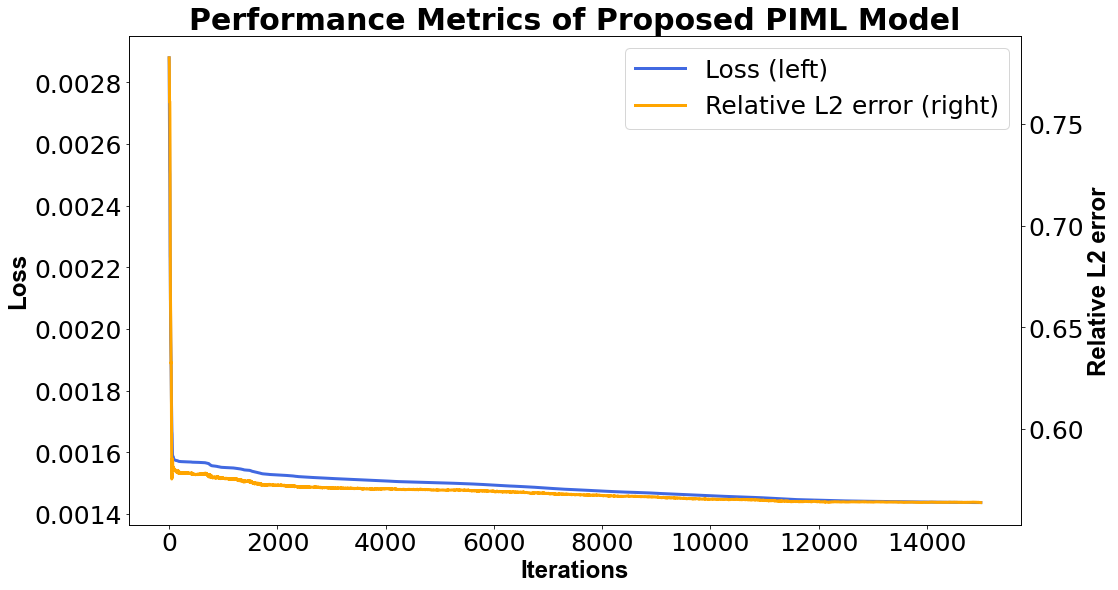

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.019351876943810884
MSE =  0.0027334630994745104
RMSE =  0.052282531494510766
L2 relative error = 0.5143175487494043
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

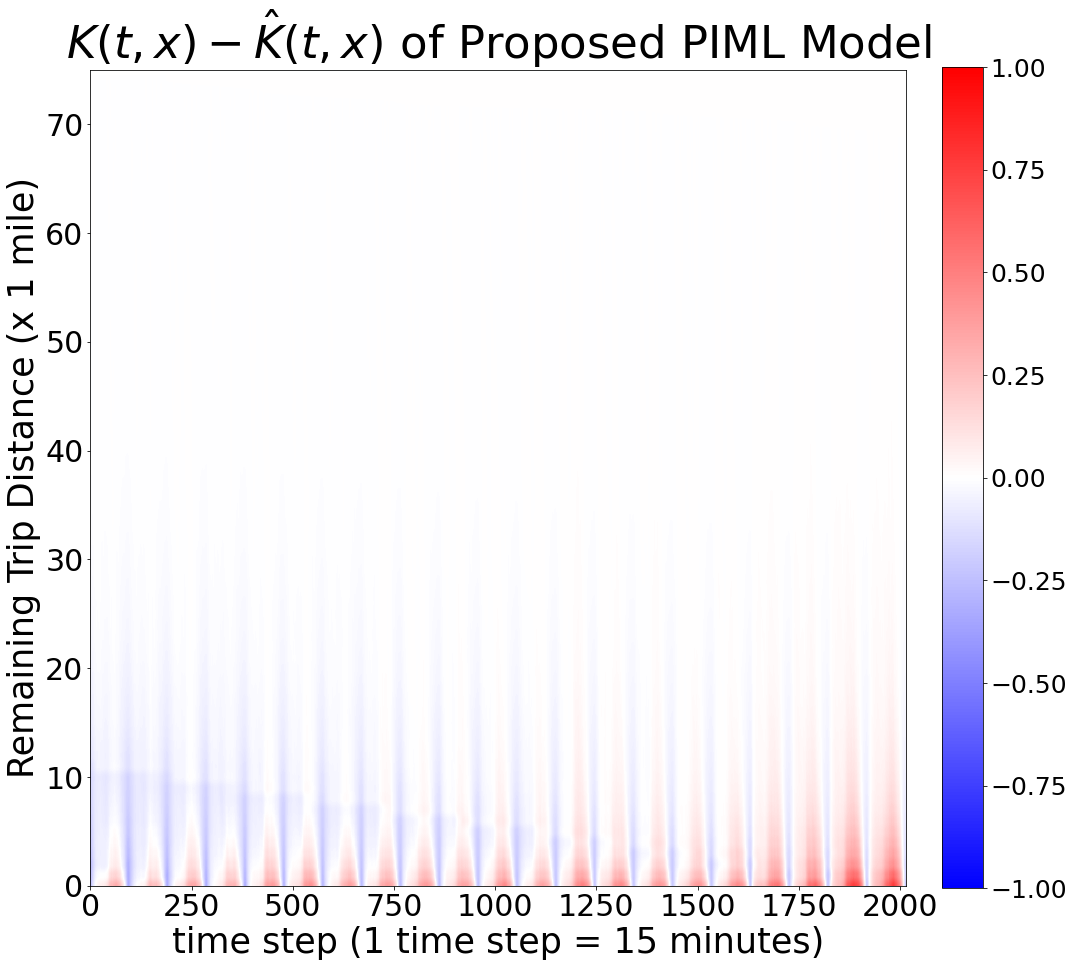

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)

plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

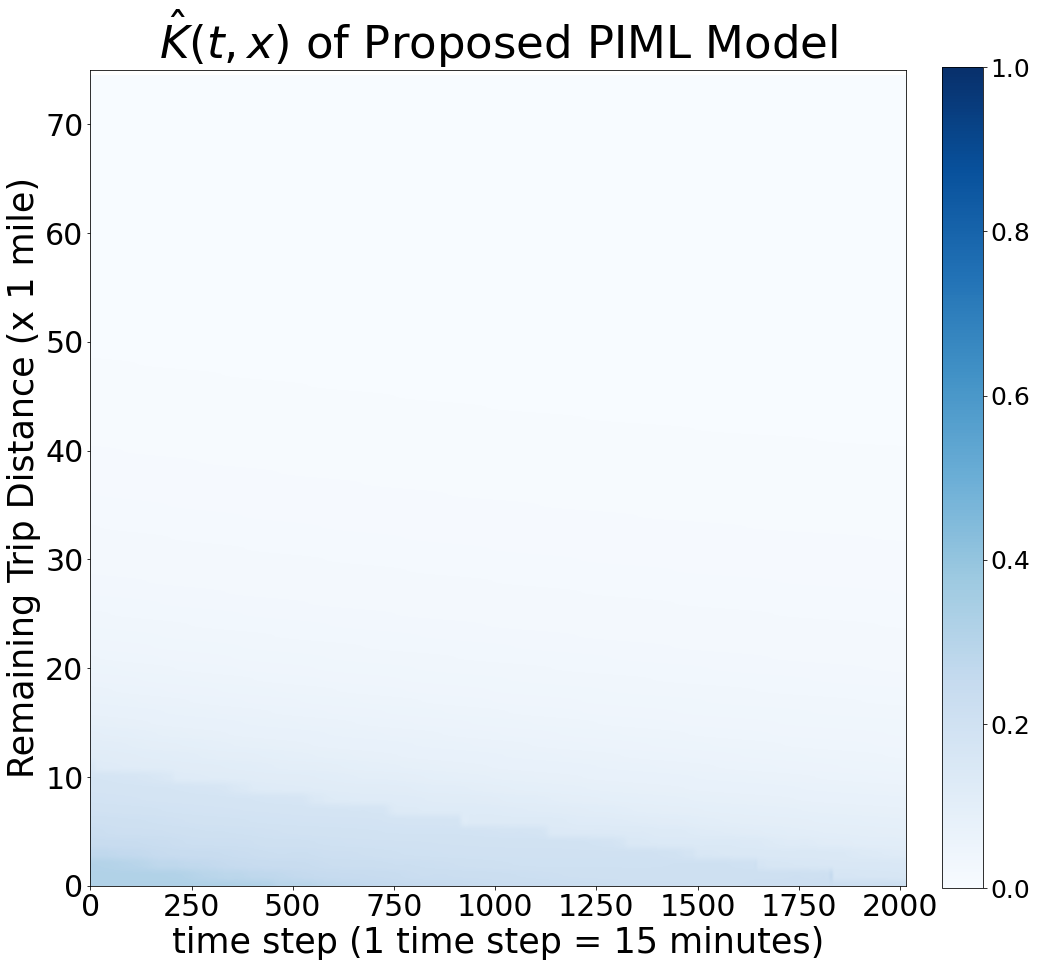

In [27]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Blues')
plt.colorbar(fraction=0.046, pad=0.04)

plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

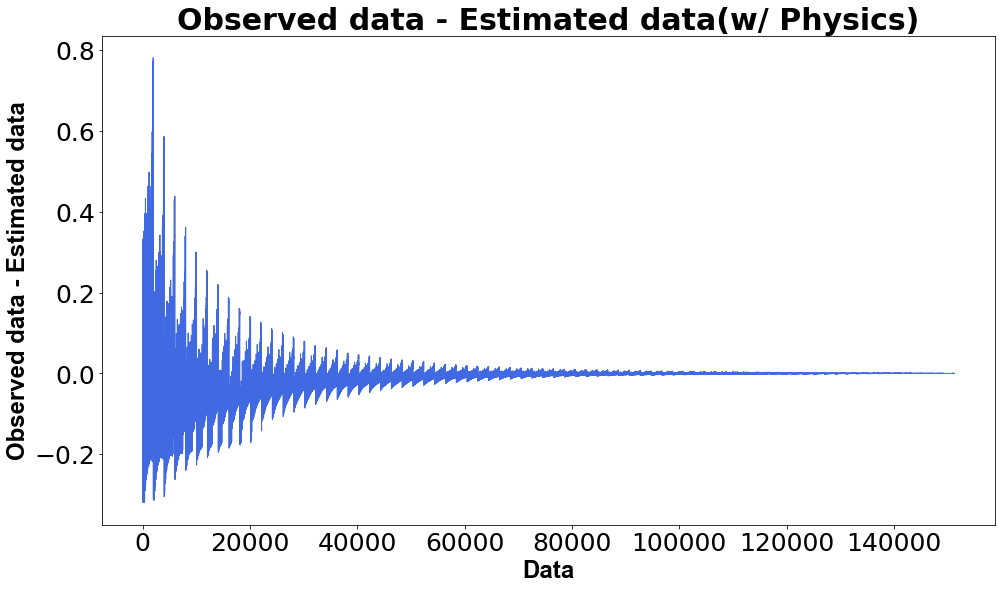

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

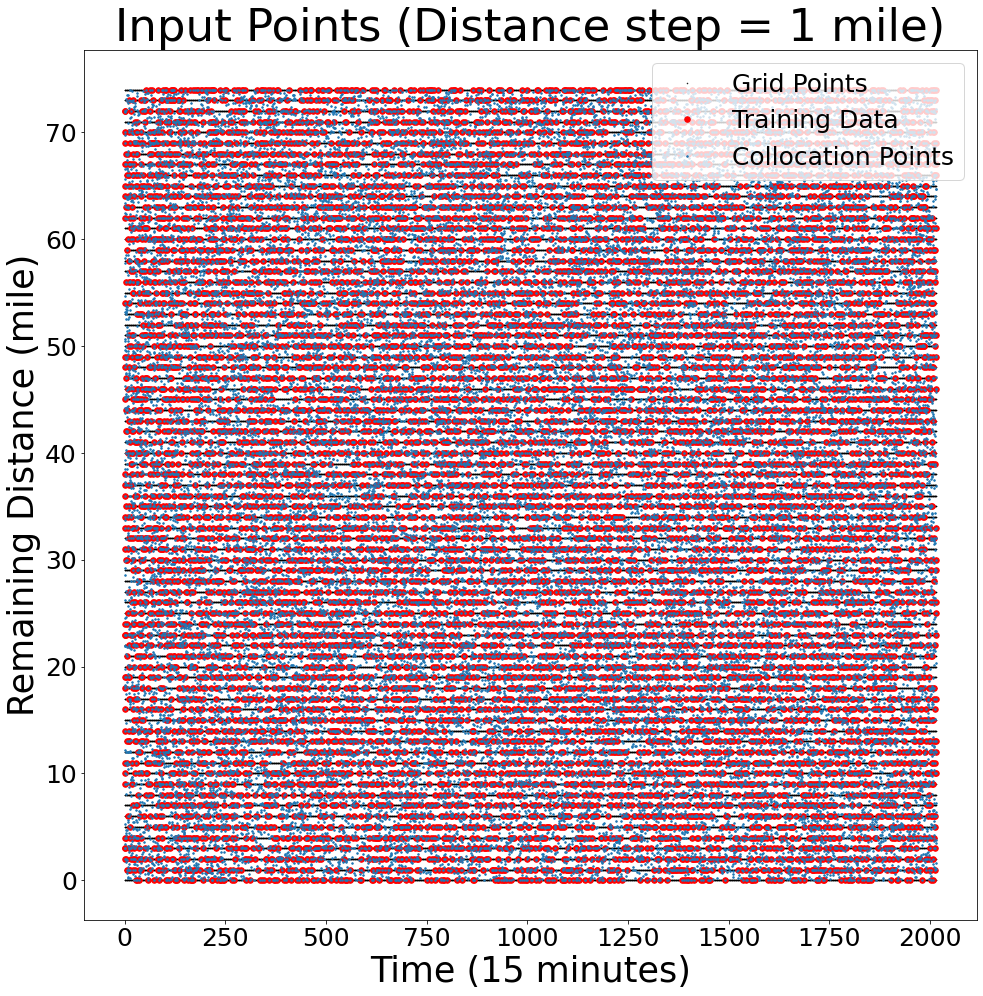

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

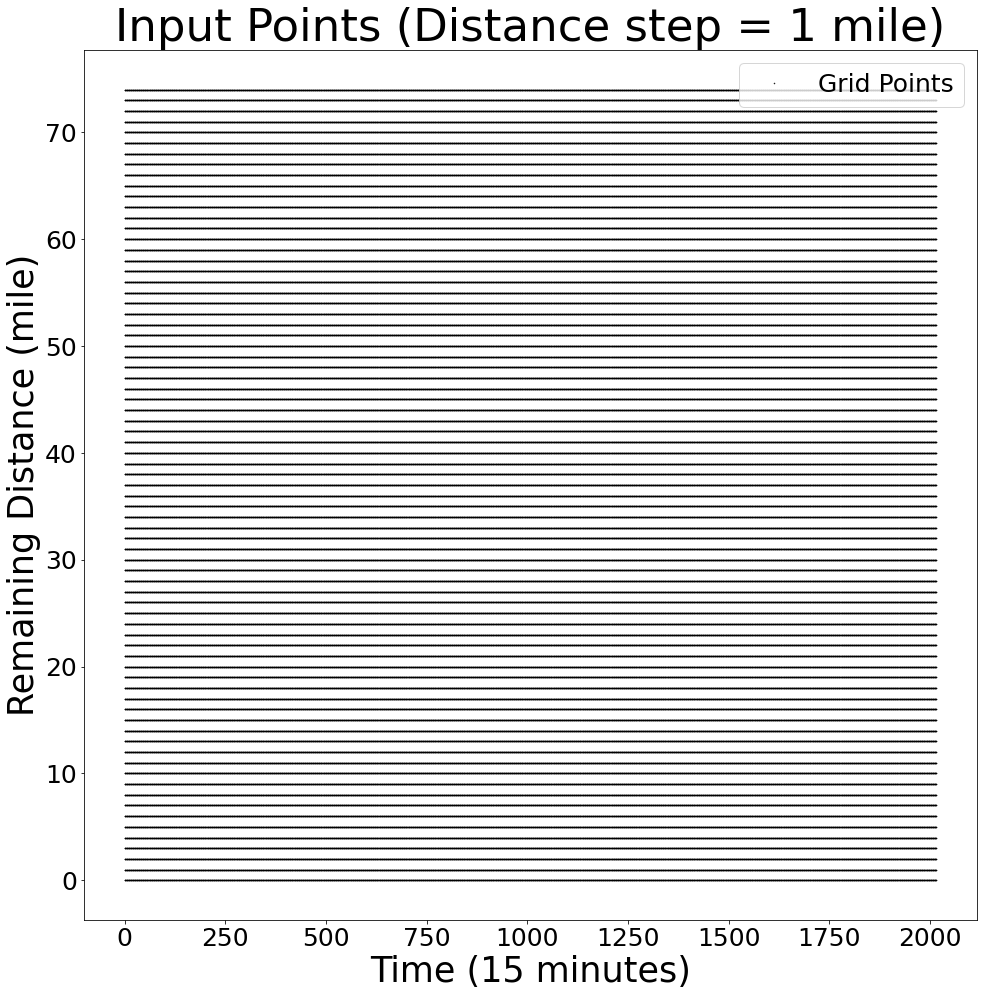

In [22]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

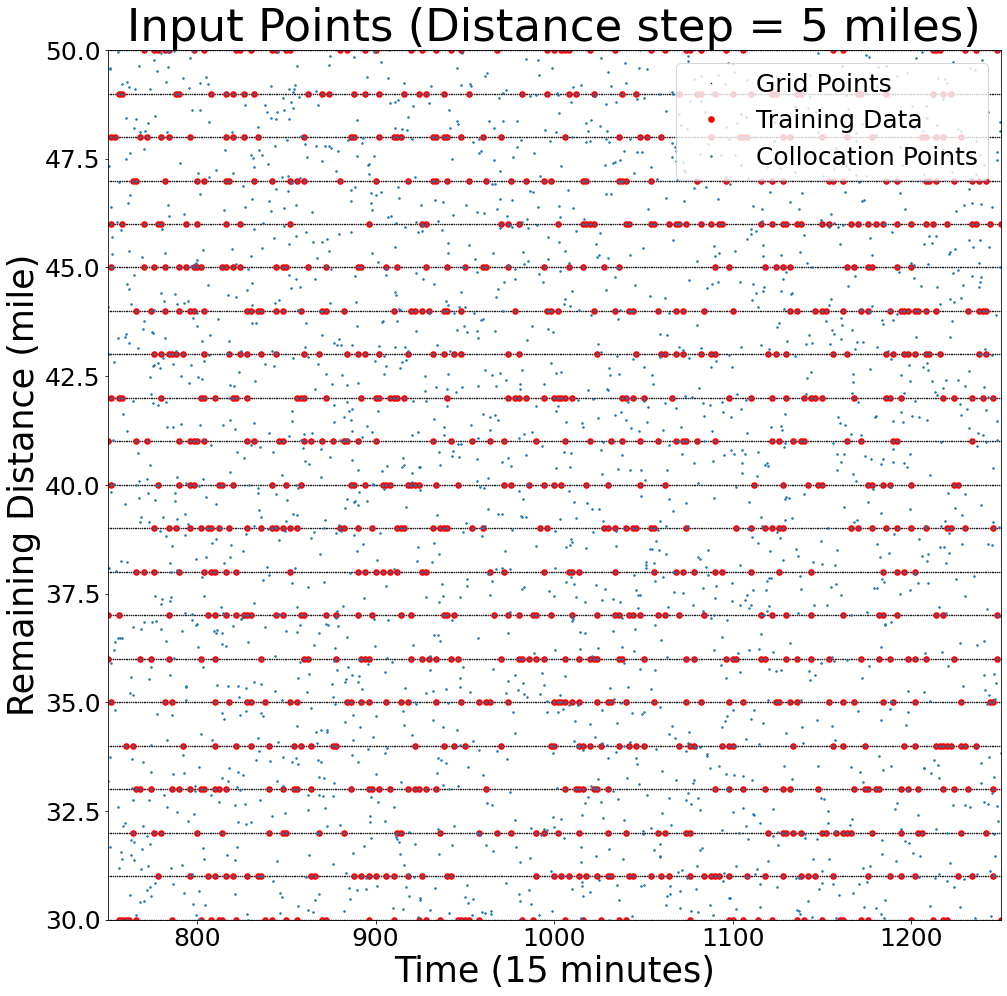

In [31]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.xlim((750,1250))
plt.ylim((30,50))
plt.title('Input Points (Distance step = 1 mile)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

In [ ]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)